
# Lab02: Compressed DenseNet for Crowd Counting

> Dataset structure:
> ```
> <DATA_ROOT>/
> ├── Lab02_CDenseNet.ipynb
> ├── CDenseNet.py
> └── data/
>     ├── video/vidf/vidf1_33_ZZZ.y/*.png  # e.g., vidf1_33_ZZZ_fFFF.png ...
>     └── gt/vidf/*.mat    # e.g., vidf1_33_ZZZ_count_2K_roi*.mat ...
> ```

## 0. Mount Google Drive

In [1]:
#from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive')
# You need to modify this part to the directory where your code is located, i.e., <DATA_ROOT>
# %cd "/content/drive/MyDrive/DL_LAB02/DL_LAB02"
import torch
torch.cuda.is_available()

True

## 1. Import Libraries

In [2]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [3]:
# ---- import library ----
import os, re, glob, random
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
from scipy.io import loadmat

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms, utils as vutils
import matplotlib.pyplot as plt

%matplotlib inline

def set_global_seed(seed: int):
  # Python
  random.seed(seed)
  # NumPy
  np.random.seed(seed)
  # PyTorch
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  print(f"[INFO] Global seed set to {seed}")

set_global_seed(37)

[INFO] Global seed set to 37


## 2. Dataset Definition

In [4]:
# File naming for vidf frames: vidf1_33_ZZZ_fFFF.png (ZZZ: 000..019, FFF: 001..200)
FNAME_RE = re.compile(r"vidf1_33_(\d{3})_f(\d{3})\.png")

# Train: 401..2900 | Val: 2901..3600 | Test: 1..400 & 3601..4000
SPLIT_RANGES = {
  "train": [(401, 2900)],
  "val":   [(2901, 3600)],
  # "test":  [(1, 400), (3601, 4000)],   # full test set
  "test":  [(3601, 3800)],             # public test set
}

In [5]:
class UCSDDataset(Dataset):
  """
  UCSD vidf frames -> (x, people_cnts) where x is grayscale image tensor, people_cnts is [r, l, t] crowd counts for the frame.
  """
  def __init__(self, split: str = "train", transform=None):
    super().__init__()
    assert split in ["train", "val", "test"]
    self.img_dir = './data/video/vidf'
    self.gt_dir  = './data/gt/vidf'

    # preprocess transform: to tensor + normalize to [-1,1]
    self.transform = transform or transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # enumerate frames that belong to this split
    self.items: List[Tuple[int, int, str]] = []  # (clip_idx, f_in_clip, path)
    pngs = sorted(glob.glob(os.path.join(self.img_dir, "**", "*.png"), recursive=True))
    for p in pngs:
      m = FNAME_RE.match(os.path.basename(p))
      if not m:
        continue
      clip_str, f_str = m.groups()
      clip_idx = int(clip_str)           # 000..019
      f_in_clip = int(f_str)             # 001..200
      gidx = clip_idx * 200 + f_in_clip  # global indexing
      for a, b in SPLIT_RANGES[split]:
        if a <= gidx <= b:
          self.items.append((clip_idx, f_in_clip, p))
          break

    # cache for per-clip count .mat files
    self._count_cache: Dict[int, Dict[str, np.ndarray]] = {}

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    clip_idx, f_in_clip, img_p = self.items[idx]
    img = Image.open(img_p).convert('L')
    x = self.transform(img)
    dmap = self._load_counts_clip(clip_idx)
    k = f_in_clip - 1  # 0-based index into 200 frames
    r = dmap.get('r', None)
    l = dmap.get('l', None)
    t = dmap.get('t', None)
    if r is None or l is None or t is None:
      raise KeyError(f"[ERROR] Missing 'r','l','t' in dirs for clip {clip_idx}. Have={list(dmap.keys())}")
    people_cnts = torch.tensor([r[k], l[k], t[k]], dtype=torch.float32)
    return x, people_cnts

  def _load_counts_clip(self, clip_idx: int) -> Dict[str, np.ndarray]:
    """
      Loader for DT mat layout:
       - file:  vidf1_33_ZZZ_count_2K_roi_mainwalkway.mat
       - key:   'cgt' (1x1 struct)
       - fields: cgt.dir (['r','l','t','n']), cgt.count (cell of 4 vectors length 200)
      Returns dict {'r': vec, 'l': vec, 't': vec} as float32.
    """
    if clip_idx in self._count_cache:
      return self._count_cache[clip_idx]

    path = os.path.join(self.gt_dir, f"vidf1_33_{clip_idx:03d}_count_2K_roi_mainwalkway.mat")
    mat = loadmat(path, squeeze_me=False, struct_as_record=False)

    # 1x1 MATLAB struct at key 'cgt'
    entry = mat['cgt'].flat[0]  # get the single struct

    # Access fields
    dirs_raw   = getattr(entry, 'dir')
    counts_raw = getattr(entry, 'count')

    # Normalize to plain Python lists
    dirs_seq   = np.squeeze(dirs_raw).ravel()
    counts_seq = np.squeeze(counts_raw).ravel()

    # Convert names to strings and counts to float arrays
    dirs_list   = [str(np.squeeze(d).item()) for d in dirs_seq]
    counts_list = [np.squeeze(c).astype(np.float32) for c in counts_seq]  # (200,) each

    # Build the map; ignore 'n' (no motion)
    dmap = {}
    for name, vec in zip(dirs_list, counts_list):
      k = name.strip().lower()
      if   k == 'r': dmap['r'] = vec
      elif k == 'l': dmap['l'] = vec
      elif k == 't': dmap['t'] = vec

    missing = [nm for nm in ('r','l','t') if nm not in dmap]
    if missing:
      raise KeyError(f"[ERROR] Missing {missing} in GT for clip {clip_idx}. dirs={dirs_list}")

    # Cache & return
    self._count_cache[clip_idx] = dmap
    return dmap

## 3. Visualize Sample Frames & Labels

Labels [r, l, t] for shown samples:
  #00 -> [8.0, 9.0, 17.0]
  #01 -> [5.0, 8.0, 13.0]
  #02 -> [10.0, 13.0, 23.0]
  #03 -> [8.0, 13.0, 21.0]


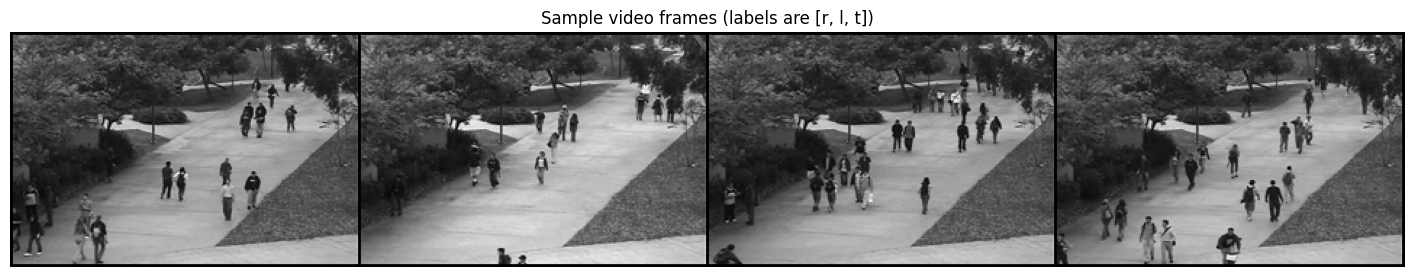

In [6]:
def visualize_samples(dataset: UCSDDataset, n: int = 4):
  """Show a grid of n sample images and print their [r,l,t] labels."""
  if len(dataset) == 0:
    print("[WARN] Dataset is empty. Please check DATA_ROOT.")
    return

  idxs = [random.randrange(len(dataset)) for _ in range(min(n, len(dataset)))]
  xs, ys = [], []
  for idx in idxs:
    x, people_cnts = dataset[idx]
    xs.append(x)
    ys.append(people_cnts.numpy())

  cols = min(8, len(xs))
  rows = int(np.ceil(len(xs) / cols))
  grid = vutils.make_grid(xs, nrow=cols, normalize=True, scale_each=True)

  plt.figure(figsize=(4.5*cols, 3.8*rows))  # Same scaling as lower function
  plt.axis('off')
  plt.title("Sample video frames (labels are [r, l, t])")
  plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap='gray')

  print("Labels [r, l, t] for shown samples:")
  for i, people_cnts in enumerate(ys):
    print(f"  #{i:02d} -> {[float(f'{v:.2f}') for v in people_cnts.tolist()]}")

try:
  _tmp_ds = UCSDDataset(split="train")
  visualize_samples(_tmp_ds, n=4)
except Exception as e:
  print("[WARN] Visualization skipped:", e)

## 4. Import Model

In [7]:
from CDenseNet import LDB, CDenseNet

model = CDenseNet(in_channel=1)

In [8]:
# Check if CDenseNet.py exists in the current directory
import os
print(os.listdir('.'))

['CDenseNet.py', 'check_pytorch.py', 'data', 'Lab02_CDenseNet.ipynb', 'summary.txt', 'TASK_Lab02_CDenseNet_01.ipynb', '__pycache__']


In [9]:
model_summary = summary(model,
                       input_size=(1, 1, 158, 238),
                       device='cuda',
                       depth=9999,  # Large int value to show full depth
                       col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
                       row_settings=["var_names"])

print(model_summary)

with open('summary.txt', 'w') as f:
  f.write(str(model_summary))

print("[INFO] Summary displayed above and saved to summary.txt")

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
CDenseNet (CDenseNet)                    [1, 1, 158, 238]          [1, 3]                    --                        --                        --
├─Sequential (stem)                      [1, 1, 158, 238]          [1, 32, 158, 238]         --                        --                        --
│    └─Conv2d (0)                        [1, 1, 158, 238]          [1, 32, 158, 238]         288                       [3, 3]                    10,829,952
│    └─BatchNorm2d (1)                   [1, 32, 158, 238]         [1, 32, 158, 238]         64                        --                        64
│    └─ReLU (2)                          [1, 32, 158, 238]         [1, 32, 158, 238]         --                        --                        --
├─Sequential (blocks)                    [1, 32, 158, 238]         [1, 32, 158, 238]         --  

## 5. Create DataLoaders

In [10]:
batch_size = 8

# Create dataset instances
train_ds = UCSDDataset(split="train")
val_ds   = UCSDDataset(split="val")
test_ds  = UCSDDataset(split="test")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"[INFO] Dataset sizes: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

[INFO] Dataset sizes: train=2500, val=700, test=200


## 6. Training Setup

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)

# you can try 10~15 at first
num_epochs = 500
# Learning rate
lr = 0.01

# Loss function
#criterion = torch.nn.MSELoss()
criterion = torch.nn.L1Loss()

# Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9, weight_decay=1e-4)
# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

[INFO] Using device: cuda


## 7. Training Loop

In [12]:
from tqdm.auto import tqdm

model = model.to(device)

ckpt_path = "model.pth"

mae_best = float('inf')

for epoch in range(1, num_epochs + 1):
  # ---------- Training phase ----------
  model.train()  # Set the model to training mode
  running_loss = 0.0
  train_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs} [Train]', leave=False, position=0, smoothing=0.1)
  for in_img, people_cnts in train_bar:
    in_img, people_cnts = in_img.to(device, non_blocking=True), people_cnts.to(device, non_blocking=True)

    #################################################
    # Please finish the "Training phase" code here.
    optimizer.zero_grad()                # reset gradients
    outputs = model(in_img)              # forward pass
    loss = criterion(outputs, people_cnts)  # compute loss
    loss.backward()                      # backprop
    optimizer.step()                     # update weights

    #################################################

    running_loss += loss.item() * people_cnts.size(0)
    train_bar.set_postfix(loss=f'{loss.item():.4f}')

  # ---------- Validation phase ----------
  model.eval()  # Set the model to evaluation mode
  val_loss = 0
  # Per-component MAE/RMSE accumulators for [r, l, t]
  abs_sum = torch.zeros(3, dtype=torch.float64)
  sqr_sum = torch.zeros(3, dtype=torch.float64)

  with torch.no_grad():
    val_bar = tqdm(val_loader, desc=f'Epoch {epoch}/{num_epochs} [Val]', leave=False, position=0, smoothing=0.1)
    for in_img, people_cnts in val_bar:
      in_img, people_cnts = in_img.to(device, non_blocking=True), people_cnts.to(device, non_blocking=True)

      ###################################################
      # Forward pass for validation
      # Please finish the "Validation phase" code here.
      outputs = model(in_img)              # forward only
      loss = criterion(outputs, people_cnts)
      val_loss += loss.item() * people_cnts.size(0)
      ###################################################

      # Calculate metrics for validation results
      err = outputs - people_cnts
      abs_sum += err.abs().sum(dim=0).double().cpu()
      sqr_sum += (err ** 2).sum(dim=0).double().cpu()
      val_bar.set_postfix(loss=f'{loss.item():.4f}')

  epoch_loss = running_loss / len(train_ds)
  avg_val_loss = val_loss / len(val_ds)
  mae = (abs_sum / len(val_ds)).tolist()
  avg_mae = sum(mae) / 3.0
  rmse = torch.sqrt(sqr_sum / len(val_ds)).tolist()
  avg_rmse = sum(rmse) / 3.0
  if scheduler:
    scheduler.step(avg_mae)

  ckpt_path_epoch = f"model_{epoch}.pth"
  torch.save(model.state_dict(), ckpt_path_epoch)

  if avg_mae < mae_best:
    mae_best = avg_mae
    print("model saved")
    torch.save(model.state_dict(), ckpt_path)

  print(f"[Epoch {epoch:2d}] "
        f"Train Loss: {epoch_loss:8.4f} | "
        f" MAE[r,l,t] = [{mae[0]:7.4f}, {mae[1]:7.4f}, {mae[2]:7.4f}] | "
        f"Avg  MAE: {avg_mae:7.4f}")
  print(f"           "
        f"  Val Loss: {avg_val_loss:8.4f} | "
        f"RMSE[r,l,t] = [{rmse[0]:7.4f}, {rmse[1]:7.4f}, {rmse[2]:7.4f}] | "
        f"Avg RMSE: {avg_rmse:7.4f}")

Epoch 1/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

model saved
[Epoch  1] Train Loss:   4.7856 |  MAE[r,l,t] = [ 4.4974,  7.8635, 12.6628] | Avg  MAE:  8.3412
             Val Loss:   8.3412 | RMSE[r,l,t] = [ 4.8511,  8.6292, 13.0065] | Avg RMSE:  8.8289


c:\Users\ray\Downloads\DL_LAB02-20251002T195738Z-1-001\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

model saved
[Epoch  2] Train Loss:   3.2069 |  MAE[r,l,t] = [ 3.6566,  3.3914,  2.5011] | Avg  MAE:  3.1831
             Val Loss:   3.1831 | RMSE[r,l,t] = [ 4.0728,  4.1573,  3.2010] | Avg RMSE:  3.8104


Epoch 3/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch  3] Train Loss:   3.1208 |  MAE[r,l,t] = [ 2.9567,  3.3091,  5.1316] | Avg  MAE:  3.7991
             Val Loss:   3.7991 | RMSE[r,l,t] = [ 3.4921,  4.0587,  5.9102] | Avg RMSE:  4.4870


Epoch 4/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch  4] Train Loss:   2.8713 |  MAE[r,l,t] = [ 2.9909,  3.9911,  6.4388] | Avg  MAE:  4.4736
             Val Loss:   4.4736 | RMSE[r,l,t] = [ 3.5336,  4.7954,  7.0837] | Avg RMSE:  5.1376


Epoch 5/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch  5] Train Loss:   2.6876 |  MAE[r,l,t] = [ 2.3464,  4.0302,  5.6144] | Avg  MAE:  3.9970
             Val Loss:   3.9970 | RMSE[r,l,t] = [ 2.8859,  4.8890,  6.3429] | Avg RMSE:  4.7059


Epoch 6/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch  6] Train Loss:   2.5502 |  MAE[r,l,t] = [ 6.0530,  5.8006, 10.9902] | Avg  MAE:  7.6146
             Val Loss:   7.6146 | RMSE[r,l,t] = [ 6.3525,  6.7029, 11.3980] | Avg RMSE:  8.1511


Epoch 7/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch  7] Train Loss:   2.6129 |  MAE[r,l,t] = [ 5.3713,  5.9394, 10.8863] | Avg  MAE:  7.3990
             Val Loss:   7.3990 | RMSE[r,l,t] = [ 5.6815,  6.8407, 11.2569] | Avg RMSE:  7.9263


Epoch 8/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch  8] Train Loss:   2.4290 |  MAE[r,l,t] = [ 5.9222,  6.4874, 12.1897] | Avg  MAE:  8.1998
             Val Loss:   8.1998 | RMSE[r,l,t] = [ 6.2113,  7.3552, 12.5157] | Avg RMSE:  8.6941


Epoch 9/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

model saved
[Epoch  9] Train Loss:   2.4306 |  MAE[r,l,t] = [ 1.9538,  3.3457,  3.2488] | Avg  MAE:  2.8494
             Val Loss:   2.8494 | RMSE[r,l,t] = [ 2.4082,  4.1382,  3.8245] | Avg RMSE:  3.4570


Epoch 10/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 10] Train Loss:   2.4451 |  MAE[r,l,t] = [ 2.8174,  4.8263,  7.3045] | Avg  MAE:  4.9827
             Val Loss:   4.9827 | RMSE[r,l,t] = [ 3.3360,  5.7281,  7.8248] | Avg RMSE:  5.6296


Epoch 11/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 11] Train Loss:   2.3760 |  MAE[r,l,t] = [ 4.1928,  5.9852, 10.2192] | Avg  MAE:  6.7990
             Val Loss:   6.7990 | RMSE[r,l,t] = [ 4.6283,  6.8747, 10.6165] | Avg RMSE:  7.3732


Epoch 12/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 12] Train Loss:   2.2739 |  MAE[r,l,t] = [ 5.5680,  7.1857, 12.7255] | Avg  MAE:  8.4931
             Val Loss:   8.4931 | RMSE[r,l,t] = [ 5.8901,  7.9583, 13.0197] | Avg RMSE:  8.9560


Epoch 13/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 13] Train Loss:   2.3172 |  MAE[r,l,t] = [ 3.5404,  4.4898,  7.2066] | Avg  MAE:  5.0789
             Val Loss:   5.0789 | RMSE[r,l,t] = [ 4.0392,  5.3294,  7.7411] | Avg RMSE:  5.7032


Epoch 14/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 14] Train Loss:   2.1943 |  MAE[r,l,t] = [ 2.7907,  4.4236,  6.3545] | Avg  MAE:  4.5229
             Val Loss:   4.5229 | RMSE[r,l,t] = [ 3.3530,  5.3168,  6.8952] | Avg RMSE:  5.1883


Epoch 15/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 15] Train Loss:   2.2035 |  MAE[r,l,t] = [ 6.1723,  8.0157, 14.1480] | Avg  MAE:  9.4453
             Val Loss:   9.4453 | RMSE[r,l,t] = [ 6.4671,  8.7258, 14.4292] | Avg RMSE:  9.8740


Epoch 16/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 16] Train Loss:   2.1685 |  MAE[r,l,t] = [ 3.9202,  5.3360,  9.1378] | Avg  MAE:  6.1314
             Val Loss:   6.1314 | RMSE[r,l,t] = [ 4.3967,  6.2322,  9.5615] | Avg RMSE:  6.7301


Epoch 17/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 17] Train Loss:   2.2106 |  MAE[r,l,t] = [ 2.0448,  4.0606,  4.7355] | Avg  MAE:  3.6136
             Val Loss:   3.6136 | RMSE[r,l,t] = [ 2.5955,  4.9099,  5.4124] | Avg RMSE:  4.3059


Epoch 18/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 18] Train Loss:   2.2826 |  MAE[r,l,t] = [ 5.9053,  8.0477, 14.0417] | Avg  MAE:  9.3316
             Val Loss:   9.3316 | RMSE[r,l,t] = [ 6.2062,  8.7707, 14.3383] | Avg RMSE:  9.7717


Epoch 19/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 19] Train Loss:   2.1187 |  MAE[r,l,t] = [ 3.8275,  5.4486,  9.0312] | Avg  MAE:  6.1024
             Val Loss:   6.1024 | RMSE[r,l,t] = [ 4.3167,  6.3334,  9.4496] | Avg RMSE:  6.6999


Epoch 20/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 20] Train Loss:   2.1396 |  MAE[r,l,t] = [ 5.9006,  8.2084, 13.7914] | Avg  MAE:  9.3001
             Val Loss:   9.3001 | RMSE[r,l,t] = [ 6.2081,  8.9027, 14.0802] | Avg RMSE:  9.7303


Epoch 21/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 21] Train Loss:   2.1176 |  MAE[r,l,t] = [ 4.0327,  6.2192, 10.1600] | Avg  MAE:  6.8040
             Val Loss:   6.8040 | RMSE[r,l,t] = [ 4.4837,  7.0816, 10.5364] | Avg RMSE:  7.3673


Epoch 22/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 22] Train Loss:   2.0802 |  MAE[r,l,t] = [ 5.8102,  8.1765, 13.9712] | Avg  MAE:  9.3193
             Val Loss:   9.3193 | RMSE[r,l,t] = [ 6.1141,  8.8661, 14.2412] | Avg RMSE:  9.7405


Epoch 23/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 23] Train Loss:   2.0490 |  MAE[r,l,t] = [ 3.1244,  5.2839,  8.5983] | Avg  MAE:  5.6689
             Val Loss:   5.6689 | RMSE[r,l,t] = [ 3.6890,  6.1716,  9.0213] | Avg RMSE:  6.2940


Epoch 24/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 24] Train Loss:   2.0853 |  MAE[r,l,t] = [ 6.3963,  8.4484, 14.7227] | Avg  MAE:  9.8558
             Val Loss:   9.8558 | RMSE[r,l,t] = [ 6.6702,  9.1352, 14.9964] | Avg RMSE: 10.2672


Epoch 25/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 25] Train Loss:   2.0742 |  MAE[r,l,t] = [ 4.6656,  6.5031, 11.1298] | Avg  MAE:  7.4328
             Val Loss:   7.4328 | RMSE[r,l,t] = [ 5.0729,  7.3653, 11.5137] | Avg RMSE:  7.9839


Epoch 26/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 26] Train Loss:   2.0412 |  MAE[r,l,t] = [ 5.9852,  7.8637, 13.3915] | Avg  MAE:  9.0801
             Val Loss:   9.0801 | RMSE[r,l,t] = [ 6.2747,  8.6065, 13.6998] | Avg RMSE:  9.5270


Epoch 27/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 27] Train Loss:   1.9289 |  MAE[r,l,t] = [ 2.1680,  4.1426,  5.5648] | Avg  MAE:  3.9585
             Val Loss:   3.9585 | RMSE[r,l,t] = [ 2.7485,  5.0100,  6.1637] | Avg RMSE:  4.6407


Epoch 28/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 28] Train Loss:   1.9974 |  MAE[r,l,t] = [ 4.5346,  6.2815, 10.6681] | Avg  MAE:  7.1614
             Val Loss:   7.1614 | RMSE[r,l,t] = [ 4.9360,  7.1261, 11.0129] | Avg RMSE:  7.6916


Epoch 29/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 29] Train Loss:   1.9388 |  MAE[r,l,t] = [ 5.1233,  6.6424, 11.8289] | Avg  MAE:  7.8648
             Val Loss:   7.8648 | RMSE[r,l,t] = [ 5.4728,  7.4516, 12.1320] | Avg RMSE:  8.3521


Epoch 30/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 30] Train Loss:   1.9104 |  MAE[r,l,t] = [ 3.5539,  5.0411,  8.5167] | Avg  MAE:  5.7039
             Val Loss:   5.7039 | RMSE[r,l,t] = [ 4.0549,  5.9287,  8.9195] | Avg RMSE:  6.3010


Epoch 31/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

model saved
[Epoch 31] Train Loss:   1.8997 |  MAE[r,l,t] = [ 1.9375,  3.0631,  2.5691] | Avg  MAE:  2.5232
             Val Loss:   2.5232 | RMSE[r,l,t] = [ 2.2043,  3.8175,  3.1187] | Avg RMSE:  3.0468


Epoch 32/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 32] Train Loss:   1.7790 |  MAE[r,l,t] = [ 5.1415,  7.3661, 12.2231] | Avg  MAE:  8.2436
             Val Loss:   8.2436 | RMSE[r,l,t] = [ 5.5004,  8.1161, 12.5315] | Avg RMSE:  8.7160


Epoch 33/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 33] Train Loss:   1.7736 |  MAE[r,l,t] = [ 5.2838,  7.1056, 12.0905] | Avg  MAE:  8.1600
             Val Loss:   8.1600 | RMSE[r,l,t] = [ 5.6338,  7.8730, 12.3968] | Avg RMSE:  8.6345


Epoch 34/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 34] Train Loss:   1.8632 |  MAE[r,l,t] = [ 2.9644,  4.3052,  6.8259] | Avg  MAE:  4.6985
             Val Loss:   4.6985 | RMSE[r,l,t] = [ 3.5435,  5.1760,  7.3297] | Avg RMSE:  5.3497


Epoch 35/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 35] Train Loss:   1.8048 |  MAE[r,l,t] = [ 5.0740,  6.8565, 11.5084] | Avg  MAE:  7.8130
             Val Loss:   7.8130 | RMSE[r,l,t] = [ 5.4320,  7.6623, 11.8408] | Avg RMSE:  8.3117


Epoch 36/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 36] Train Loss:   1.9050 |  MAE[r,l,t] = [ 3.4142,  4.8838,  7.8453] | Avg  MAE:  5.3811
             Val Loss:   5.3811 | RMSE[r,l,t] = [ 3.9453,  5.7700,  8.2748] | Avg RMSE:  5.9967


Epoch 37/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 37] Train Loss:   1.8105 |  MAE[r,l,t] = [ 4.1451,  5.5812,  9.6021] | Avg  MAE:  6.4428
             Val Loss:   6.4428 | RMSE[r,l,t] = [ 4.5991,  6.5000, 10.0629] | Avg RMSE:  7.0540


Epoch 38/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 38] Train Loss:   1.7827 |  MAE[r,l,t] = [ 5.8472,  7.3807, 13.1230] | Avg  MAE:  8.7836
             Val Loss:   8.7836 | RMSE[r,l,t] = [ 6.1620,  8.1522, 13.4346] | Avg RMSE:  9.2496


Epoch 39/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 39] Train Loss:   1.8346 |  MAE[r,l,t] = [ 3.4639,  5.7480,  8.9786] | Avg  MAE:  6.0635
             Val Loss:   6.0635 | RMSE[r,l,t] = [ 3.9881,  6.6453,  9.4027] | Avg RMSE:  6.6787


Epoch 40/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 40] Train Loss:   1.8656 |  MAE[r,l,t] = [ 5.8231,  7.2644, 12.9146] | Avg  MAE:  8.6674
             Val Loss:   8.6674 | RMSE[r,l,t] = [ 6.1282,  8.0502, 13.2282] | Avg RMSE:  9.1355


Epoch 41/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 41] Train Loss:   1.7871 |  MAE[r,l,t] = [ 2.5565,  4.5065,  6.0009] | Avg  MAE:  4.3546
             Val Loss:   4.3546 | RMSE[r,l,t] = [ 3.1525,  5.3770,  6.5429] | Avg RMSE:  5.0242


Epoch 42/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 42] Train Loss:   1.7768 |  MAE[r,l,t] = [ 2.6893,  4.4318,  6.5356] | Avg  MAE:  4.5522
             Val Loss:   4.5522 | RMSE[r,l,t] = [ 3.2912,  5.2959,  7.0222] | Avg RMSE:  5.2031


Epoch 43/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 43] Train Loss:   1.7593 |  MAE[r,l,t] = [ 4.8387,  6.6065, 11.2830] | Avg  MAE:  7.5760
             Val Loss:   7.5760 | RMSE[r,l,t] = [ 5.2250,  7.4331, 11.6214] | Avg RMSE:  8.0932


Epoch 44/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 44] Train Loss:   1.7481 |  MAE[r,l,t] = [ 3.4307,  5.1449,  8.4095] | Avg  MAE:  5.6617
             Val Loss:   5.6617 | RMSE[r,l,t] = [ 3.9722,  6.0556,  8.8761] | Avg RMSE:  6.3013


Epoch 45/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 45] Train Loss:   1.7500 |  MAE[r,l,t] = [ 4.0192,  6.0718, 10.2221] | Avg  MAE:  6.7710
             Val Loss:   6.7710 | RMSE[r,l,t] = [ 4.4883,  6.9318, 10.5671] | Avg RMSE:  7.3291


Epoch 46/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 46] Train Loss:   1.7100 |  MAE[r,l,t] = [ 6.0477,  8.0252, 13.7345] | Avg  MAE:  9.2691
             Val Loss:   9.2691 | RMSE[r,l,t] = [ 6.3975,  8.7033, 14.0272] | Avg RMSE:  9.7093


Epoch 47/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 47] Train Loss:   1.7362 |  MAE[r,l,t] = [ 3.8111,  5.7485,  9.1646] | Avg  MAE:  6.2414
             Val Loss:   6.2414 | RMSE[r,l,t] = [ 4.2996,  6.6027,  9.5285] | Avg RMSE:  6.8103


Epoch 48/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 48] Train Loss:   1.6886 |  MAE[r,l,t] = [ 2.1123,  3.8007,  4.5155] | Avg  MAE:  3.4762
             Val Loss:   3.4762 | RMSE[r,l,t] = [ 2.6645,  4.5850,  5.2267] | Avg RMSE:  4.1587


Epoch 49/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 49] Train Loss:   1.7351 |  MAE[r,l,t] = [ 4.3932,  5.8012, 10.0061] | Avg  MAE:  6.7335
             Val Loss:   6.7335 | RMSE[r,l,t] = [ 4.8268,  6.6580, 10.3507] | Avg RMSE:  7.2785


Epoch 50/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 50/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 50] Train Loss:   1.7592 |  MAE[r,l,t] = [ 2.6603,  4.2547,  6.2904] | Avg  MAE:  4.4018
             Val Loss:   4.4018 | RMSE[r,l,t] = [ 3.2687,  5.1081,  6.8985] | Avg RMSE:  5.0918


Epoch 51/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 51/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 51] Train Loss:   1.6934 |  MAE[r,l,t] = [ 3.5312,  4.9153,  8.4553] | Avg  MAE:  5.6340
             Val Loss:   5.6340 | RMSE[r,l,t] = [ 4.0193,  5.7937,  8.8447] | Avg RMSE:  6.2192


Epoch 52/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 52/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 52] Train Loss:   1.7230 |  MAE[r,l,t] = [ 2.2300,  3.7413,  5.0393] | Avg  MAE:  3.6702
             Val Loss:   3.6702 | RMSE[r,l,t] = [ 2.8008,  4.5510,  5.6647] | Avg RMSE:  4.3389


Epoch 53/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 53/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 53] Train Loss:   1.7341 |  MAE[r,l,t] = [ 3.2958,  4.6271,  7.6859] | Avg  MAE:  5.2030
             Val Loss:   5.2030 | RMSE[r,l,t] = [ 3.8340,  5.5220,  8.1959] | Avg RMSE:  5.8506


Epoch 54/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 54/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 54] Train Loss:   1.6775 |  MAE[r,l,t] = [ 4.4059,  6.5746, 11.3167] | Avg  MAE:  7.4324
             Val Loss:   7.4324 | RMSE[r,l,t] = [ 4.8365,  7.4066, 11.6611] | Avg RMSE:  7.9681


Epoch 55/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 55/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 55] Train Loss:   1.7347 |  MAE[r,l,t] = [ 3.4156,  5.6436,  8.9469] | Avg  MAE:  6.0020
             Val Loss:   6.0020 | RMSE[r,l,t] = [ 3.9251,  6.5246,  9.3482] | Avg RMSE:  6.5993


Epoch 56/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 56/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 56] Train Loss:   1.6905 |  MAE[r,l,t] = [ 2.6870,  3.9526,  6.0926] | Avg  MAE:  4.2441
             Val Loss:   4.2441 | RMSE[r,l,t] = [ 3.2705,  4.7715,  6.6126] | Avg RMSE:  4.8849


Epoch 57/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 57/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 57] Train Loss:   1.7300 |  MAE[r,l,t] = [ 3.0339,  5.2242,  8.4405] | Avg  MAE:  5.5662
             Val Loss:   5.5662 | RMSE[r,l,t] = [ 3.5959,  6.0942,  8.8320] | Avg RMSE:  6.1740


Epoch 58/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 58/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 58] Train Loss:   1.6664 |  MAE[r,l,t] = [ 3.3939,  5.1590,  8.2394] | Avg  MAE:  5.5974
             Val Loss:   5.5974 | RMSE[r,l,t] = [ 3.9050,  6.0248,  8.6282] | Avg RMSE:  6.1860


Epoch 59/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 59/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 59] Train Loss:   1.6726 |  MAE[r,l,t] = [ 2.5555,  4.5402,  6.6589] | Avg  MAE:  4.5849
             Val Loss:   4.5849 | RMSE[r,l,t] = [ 3.1558,  5.4279,  7.1728] | Avg RMSE:  5.2522


Epoch 60/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 60/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 60] Train Loss:   1.6791 |  MAE[r,l,t] = [ 2.9917,  4.9152,  7.6657] | Avg  MAE:  5.1909
             Val Loss:   5.1909 | RMSE[r,l,t] = [ 3.5383,  5.7920,  8.1405] | Avg RMSE:  5.8236


Epoch 61/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 61/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 61] Train Loss:   1.6436 |  MAE[r,l,t] = [ 3.3244,  5.0090,  8.4938] | Avg  MAE:  5.6091
             Val Loss:   5.6091 | RMSE[r,l,t] = [ 3.8507,  5.8923,  8.8744] | Avg RMSE:  6.2058


Epoch 62/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 62/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 62] Train Loss:   1.6146 |  MAE[r,l,t] = [ 2.7313,  4.4667,  6.2634] | Avg  MAE:  4.4872
             Val Loss:   4.4872 | RMSE[r,l,t] = [ 3.3169,  5.3218,  6.8068] | Avg RMSE:  5.1485


Epoch 63/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 63/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 63] Train Loss:   1.6473 |  MAE[r,l,t] = [ 4.1634,  5.6378,  9.9355] | Avg  MAE:  6.5789
             Val Loss:   6.5789 | RMSE[r,l,t] = [ 4.6095,  6.5112, 10.2937] | Avg RMSE:  7.1381


Epoch 64/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 64/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 64] Train Loss:   1.6445 |  MAE[r,l,t] = [ 3.4151,  5.0344,  8.1337] | Avg  MAE:  5.5278
             Val Loss:   5.5278 | RMSE[r,l,t] = [ 3.9247,  5.9175,  8.5855] | Avg RMSE:  6.1425


Epoch 65/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 65/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 65] Train Loss:   1.5830 |  MAE[r,l,t] = [ 4.3631,  6.3323, 10.7931] | Avg  MAE:  7.1629
             Val Loss:   7.1629 | RMSE[r,l,t] = [ 4.7959,  7.1661, 11.1412] | Avg RMSE:  7.7011


Epoch 66/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 66/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 66] Train Loss:   1.6266 |  MAE[r,l,t] = [ 2.1349,  3.4894,  4.4987] | Avg  MAE:  3.3743
             Val Loss:   3.3743 | RMSE[r,l,t] = [ 2.6842,  4.2351,  5.1193] | Avg RMSE:  4.0129


Epoch 67/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 67/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 67] Train Loss:   1.6209 |  MAE[r,l,t] = [ 4.0552,  5.7908,  9.8536] | Avg  MAE:  6.5665
             Val Loss:   6.5665 | RMSE[r,l,t] = [ 4.5081,  6.6634, 10.2083] | Avg RMSE:  7.1266


Epoch 68/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 68/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 68] Train Loss:   1.5912 |  MAE[r,l,t] = [ 4.0283,  5.5361,  9.3542] | Avg  MAE:  6.3062
             Val Loss:   6.3062 | RMSE[r,l,t] = [ 4.4846,  6.4008,  9.6895] | Avg RMSE:  6.8583


Epoch 69/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 69/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 69] Train Loss:   1.6401 |  MAE[r,l,t] = [ 3.3370,  5.3622,  8.8196] | Avg  MAE:  5.8396
             Val Loss:   5.8396 | RMSE[r,l,t] = [ 3.8638,  6.2229,  9.1922] | Avg RMSE:  6.4263


Epoch 70/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 70/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 70] Train Loss:   1.6093 |  MAE[r,l,t] = [ 3.7461,  5.3813,  8.9221] | Avg  MAE:  6.0165
             Val Loss:   6.0165 | RMSE[r,l,t] = [ 4.2264,  6.2348,  9.2804] | Avg RMSE:  6.5805


Epoch 71/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 71/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 71] Train Loss:   1.5949 |  MAE[r,l,t] = [ 3.6946,  5.4919,  9.1446] | Avg  MAE:  6.1103
             Val Loss:   6.1103 | RMSE[r,l,t] = [ 4.1694,  6.3772,  9.5410] | Avg RMSE:  6.6959


Epoch 72/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 72/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 72] Train Loss:   1.6246 |  MAE[r,l,t] = [ 3.8589,  5.6413,  9.4979] | Avg  MAE:  6.3327
             Val Loss:   6.3327 | RMSE[r,l,t] = [ 4.3118,  6.5115,  9.8439] | Avg RMSE:  6.8891


Epoch 73/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 73/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 73] Train Loss:   1.5788 |  MAE[r,l,t] = [ 3.1354,  4.7014,  7.3625] | Avg  MAE:  5.0665
             Val Loss:   5.0665 | RMSE[r,l,t] = [ 3.6544,  5.5230,  7.8093] | Avg RMSE:  5.6622


Epoch 74/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 74/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 74] Train Loss:   1.6230 |  MAE[r,l,t] = [ 3.8868,  4.7114,  8.4410] | Avg  MAE:  5.6797
             Val Loss:   5.6797 | RMSE[r,l,t] = [ 4.3421,  5.5538,  8.8256] | Avg RMSE:  6.2405


Epoch 75/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 75/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 75] Train Loss:   1.6157 |  MAE[r,l,t] = [ 2.3857,  4.4146,  6.1234] | Avg  MAE:  4.3079
             Val Loss:   4.3079 | RMSE[r,l,t] = [ 2.9730,  5.2579,  6.6453] | Avg RMSE:  4.9587


Epoch 76/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 76/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 76] Train Loss:   1.5813 |  MAE[r,l,t] = [ 2.3336,  4.3191,  6.3017] | Avg  MAE:  4.3181
             Val Loss:   4.3181 | RMSE[r,l,t] = [ 2.9164,  5.1629,  6.8238] | Avg RMSE:  4.9677


Epoch 77/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 77/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 77] Train Loss:   1.5691 |  MAE[r,l,t] = [ 2.1397,  3.1744,  3.8499] | Avg  MAE:  3.0547
             Val Loss:   3.0547 | RMSE[r,l,t] = [ 2.6749,  3.9577,  4.4753] | Avg RMSE:  3.7026


Epoch 78/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 78/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 78] Train Loss:   1.5810 |  MAE[r,l,t] = [ 2.6164,  4.4761,  6.6379] | Avg  MAE:  4.5768
             Val Loss:   4.5768 | RMSE[r,l,t] = [ 3.1742,  5.2962,  7.1349] | Avg RMSE:  5.2018


Epoch 79/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 79/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 79] Train Loss:   1.5396 |  MAE[r,l,t] = [ 2.7873,  4.0151,  6.4636] | Avg  MAE:  4.4220
             Val Loss:   4.4220 | RMSE[r,l,t] = [ 3.3388,  4.8038,  6.9446] | Avg RMSE:  5.0291


Epoch 80/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 80/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 80] Train Loss:   1.5868 |  MAE[r,l,t] = [ 2.6717,  4.4187,  6.9966] | Avg  MAE:  4.6957
             Val Loss:   4.6957 | RMSE[r,l,t] = [ 3.2440,  5.2583,  7.4573] | Avg RMSE:  5.3199


Epoch 81/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 81/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 81] Train Loss:   1.5466 |  MAE[r,l,t] = [ 3.2458,  5.2643,  8.1535] | Avg  MAE:  5.5545
             Val Loss:   5.5545 | RMSE[r,l,t] = [ 3.7642,  6.1161,  8.5625] | Avg RMSE:  6.1476


Epoch 82/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 82/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 82] Train Loss:   1.5578 |  MAE[r,l,t] = [ 2.8393,  4.1451,  6.5035] | Avg  MAE:  4.4960
             Val Loss:   4.4960 | RMSE[r,l,t] = [ 3.4339,  4.9636,  6.9503] | Avg RMSE:  5.1160


Epoch 83/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 83/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 83] Train Loss:   1.5134 |  MAE[r,l,t] = [ 1.8237,  4.3158,  4.5338] | Avg  MAE:  3.5578
             Val Loss:   3.5578 | RMSE[r,l,t] = [ 2.1990,  5.1522,  5.1537] | Avg RMSE:  4.1683


Epoch 84/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 84/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 84] Train Loss:   1.6188 |  MAE[r,l,t] = [ 4.2215,  5.9817, 10.2660] | Avg  MAE:  6.8231
             Val Loss:   6.8231 | RMSE[r,l,t] = [ 4.6531,  6.8477, 10.6010] | Avg RMSE:  7.3673


Epoch 85/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 85/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 85] Train Loss:   1.5582 |  MAE[r,l,t] = [ 3.4331,  4.9261,  7.8699] | Avg  MAE:  5.4097
             Val Loss:   5.4097 | RMSE[r,l,t] = [ 3.9228,  5.7774,  8.2479] | Avg RMSE:  5.9827


Epoch 86/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 86/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 86] Train Loss:   1.5493 |  MAE[r,l,t] = [ 3.6026,  4.3088,  7.2116] | Avg  MAE:  5.0410
             Val Loss:   5.0410 | RMSE[r,l,t] = [ 4.0727,  5.1257,  7.6761] | Avg RMSE:  5.6248


Epoch 87/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 87/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 87] Train Loss:   1.5850 |  MAE[r,l,t] = [ 3.4300,  4.8306,  7.7719] | Avg  MAE:  5.3442
             Val Loss:   5.3442 | RMSE[r,l,t] = [ 3.9361,  5.7025,  8.2260] | Avg RMSE:  5.9549


Epoch 88/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 88/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 88] Train Loss:   1.5023 |  MAE[r,l,t] = [ 3.2958,  4.7573,  7.9340] | Avg  MAE:  5.3290
             Val Loss:   5.3290 | RMSE[r,l,t] = [ 3.8146,  5.5909,  8.3333] | Avg RMSE:  5.9129


Epoch 89/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 89/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 89] Train Loss:   1.4939 |  MAE[r,l,t] = [ 3.2470,  4.6000,  7.5445] | Avg  MAE:  5.1305
             Val Loss:   5.1305 | RMSE[r,l,t] = [ 3.8149,  5.4409,  7.9646] | Avg RMSE:  5.7401


Epoch 90/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 90/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 90] Train Loss:   1.5292 |  MAE[r,l,t] = [ 3.1125,  4.1457,  6.6928] | Avg  MAE:  4.6503
             Val Loss:   4.6503 | RMSE[r,l,t] = [ 3.6548,  4.9837,  7.1792] | Avg RMSE:  5.2726


Epoch 91/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 91/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 91] Train Loss:   1.5182 |  MAE[r,l,t] = [ 3.5327,  5.1656,  8.3473] | Avg  MAE:  5.6819
             Val Loss:   5.6819 | RMSE[r,l,t] = [ 4.0424,  6.0445,  8.7569] | Avg RMSE:  6.2813


Epoch 92/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 92/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 92] Train Loss:   1.5514 |  MAE[r,l,t] = [ 2.1954,  3.6428,  4.8451] | Avg  MAE:  3.5611
             Val Loss:   3.5611 | RMSE[r,l,t] = [ 2.7811,  4.4652,  5.4771] | Avg RMSE:  4.2412


Epoch 93/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 93/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 93] Train Loss:   1.5904 |  MAE[r,l,t] = [ 2.7390,  4.2119,  6.4188] | Avg  MAE:  4.4565
             Val Loss:   4.4565 | RMSE[r,l,t] = [ 3.3338,  5.0546,  6.9305] | Avg RMSE:  5.1063


Epoch 94/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 94/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 94] Train Loss:   1.5753 |  MAE[r,l,t] = [ 3.5503,  5.0733,  8.4353] | Avg  MAE:  5.6863
             Val Loss:   5.6863 | RMSE[r,l,t] = [ 4.0394,  5.9475,  8.8407] | Avg RMSE:  6.2759


Epoch 95/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 95/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 95] Train Loss:   1.5564 |  MAE[r,l,t] = [ 3.8613,  5.0781,  8.8114] | Avg  MAE:  5.9169
             Val Loss:   5.9169 | RMSE[r,l,t] = [ 4.3235,  5.9585,  9.2185] | Avg RMSE:  6.5002


Epoch 96/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 96/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 96] Train Loss:   1.5547 |  MAE[r,l,t] = [ 2.4951,  4.0638,  5.9521] | Avg  MAE:  4.1703
             Val Loss:   4.1703 | RMSE[r,l,t] = [ 3.0933,  4.8659,  6.4989] | Avg RMSE:  4.8194


Epoch 97/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 97/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

model saved
[Epoch 97] Train Loss:   1.5169 |  MAE[r,l,t] = [ 1.8860,  2.8943,  2.7570] | Avg  MAE:  2.5124
             Val Loss:   2.5124 | RMSE[r,l,t] = [ 2.2142,  3.6076,  3.3345] | Avg RMSE:  3.0521


Epoch 98/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 98/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 98] Train Loss:   1.5219 |  MAE[r,l,t] = [ 3.6185,  4.8757,  7.8691] | Avg  MAE:  5.4544
             Val Loss:   5.4544 | RMSE[r,l,t] = [ 4.0897,  5.7264,  8.3043] | Avg RMSE:  6.0401


Epoch 99/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 99/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 99] Train Loss:   1.5412 |  MAE[r,l,t] = [ 2.3255,  3.9770,  5.6917] | Avg  MAE:  3.9981
             Val Loss:   3.9981 | RMSE[r,l,t] = [ 2.9143,  4.7776,  6.2600] | Avg RMSE:  4.6506


Epoch 100/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 100/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 100] Train Loss:   1.5103 |  MAE[r,l,t] = [ 2.1090,  3.3801,  4.5925] | Avg  MAE:  3.3605
             Val Loss:   3.3605 | RMSE[r,l,t] = [ 2.6527,  4.1577,  5.2019] | Avg RMSE:  4.0041


Epoch 101/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 101/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 101] Train Loss:   1.5048 |  MAE[r,l,t] = [ 1.8981,  3.4043,  4.0327] | Avg  MAE:  3.1117
             Val Loss:   3.1117 | RMSE[r,l,t] = [ 2.3169,  4.1600,  4.6646] | Avg RMSE:  3.7138


Epoch 102/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 102/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 102] Train Loss:   1.5130 |  MAE[r,l,t] = [ 1.8138,  3.2614,  3.5143] | Avg  MAE:  2.8632
             Val Loss:   2.8632 | RMSE[r,l,t] = [ 2.1517,  4.0253,  4.1507] | Avg RMSE:  3.4426


Epoch 103/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 103/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 103] Train Loss:   1.4441 |  MAE[r,l,t] = [ 4.2030,  5.8833, 10.1601] | Avg  MAE:  6.7488
             Val Loss:   6.7488 | RMSE[r,l,t] = [ 4.6309,  6.7510, 10.5236] | Avg RMSE:  7.3018


Epoch 104/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 104/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 104] Train Loss:   1.5716 |  MAE[r,l,t] = [ 3.0980,  3.8975,  5.8572] | Avg  MAE:  4.2842
             Val Loss:   4.2842 | RMSE[r,l,t] = [ 3.6130,  4.6970,  6.3352] | Avg RMSE:  4.8817


Epoch 105/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 105/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 105] Train Loss:   1.4588 |  MAE[r,l,t] = [ 2.9052,  4.7751,  7.5439] | Avg  MAE:  5.0747
             Val Loss:   5.0747 | RMSE[r,l,t] = [ 3.4570,  5.6263,  8.0096] | Avg RMSE:  5.6977


Epoch 106/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 106/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 106] Train Loss:   1.5163 |  MAE[r,l,t] = [ 1.8668,  3.3380,  3.9410] | Avg  MAE:  3.0486
             Val Loss:   3.0486 | RMSE[r,l,t] = [ 2.2786,  4.1325,  4.6303] | Avg RMSE:  3.6805


Epoch 107/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 107/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 107] Train Loss:   1.4577 |  MAE[r,l,t] = [ 2.9665,  4.0679,  6.6129] | Avg  MAE:  4.5491
             Val Loss:   4.5491 | RMSE[r,l,t] = [ 3.5220,  4.8823,  7.1205] | Avg RMSE:  5.1749


Epoch 108/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 108/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 108] Train Loss:   1.4406 |  MAE[r,l,t] = [ 2.6758,  4.8551,  7.4949] | Avg  MAE:  5.0086
             Val Loss:   5.0086 | RMSE[r,l,t] = [ 3.2659,  5.7401,  7.9564] | Avg RMSE:  5.6541


Epoch 109/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 109/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 109] Train Loss:   1.4636 |  MAE[r,l,t] = [ 3.4729,  5.7525,  9.0857] | Avg  MAE:  6.1037
             Val Loss:   6.1037 | RMSE[r,l,t] = [ 3.9630,  6.6268,  9.4804] | Avg RMSE:  6.6901


Epoch 110/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 110/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 110] Train Loss:   1.4849 |  MAE[r,l,t] = [ 2.4293,  3.9362,  5.8715] | Avg  MAE:  4.0790
             Val Loss:   4.0790 | RMSE[r,l,t] = [ 3.0345,  4.7652,  6.4403] | Avg RMSE:  4.7467


Epoch 111/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 111/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 111] Train Loss:   1.4375 |  MAE[r,l,t] = [ 3.7598,  5.7387,  9.1092] | Avg  MAE:  6.2026
             Val Loss:   6.2026 | RMSE[r,l,t] = [ 4.2035,  6.6177,  9.4941] | Avg RMSE:  6.7718


Epoch 112/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 112/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 112] Train Loss:   1.5248 |  MAE[r,l,t] = [ 3.2606,  4.7213,  8.1570] | Avg  MAE:  5.3796
             Val Loss:   5.3796 | RMSE[r,l,t] = [ 3.7710,  5.5862,  8.6242] | Avg RMSE:  5.9938


Epoch 113/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 113/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 113] Train Loss:   1.5346 |  MAE[r,l,t] = [ 2.2364,  3.8096,  5.3456] | Avg  MAE:  3.7972
             Val Loss:   3.7972 | RMSE[r,l,t] = [ 2.8079,  4.6284,  5.9426] | Avg RMSE:  4.4596


Epoch 114/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 114/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 114] Train Loss:   1.4906 |  MAE[r,l,t] = [ 2.0563,  3.5901,  4.7777] | Avg  MAE:  3.4747
             Val Loss:   3.4747 | RMSE[r,l,t] = [ 2.6069,  4.4018,  5.4278] | Avg RMSE:  4.1455


Epoch 115/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 115/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 115] Train Loss:   1.4812 |  MAE[r,l,t] = [ 3.5646,  4.9137,  7.8514] | Avg  MAE:  5.4432
             Val Loss:   5.4432 | RMSE[r,l,t] = [ 4.0331,  5.7652,  8.3004] | Avg RMSE:  6.0329


Epoch 116/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 116/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 116] Train Loss:   1.4911 |  MAE[r,l,t] = [ 2.6494,  3.9905,  5.9926] | Avg  MAE:  4.2108
             Val Loss:   4.2108 | RMSE[r,l,t] = [ 3.2399,  4.7802,  6.5412] | Avg RMSE:  4.8537


Epoch 117/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 117/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 117] Train Loss:   1.4838 |  MAE[r,l,t] = [ 3.8101,  5.6222,  9.3188] | Avg  MAE:  6.2504
             Val Loss:   6.2504 | RMSE[r,l,t] = [ 4.2806,  6.4991,  9.7162] | Avg RMSE:  6.8320


Epoch 118/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 118/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 118] Train Loss:   1.5139 |  MAE[r,l,t] = [ 2.0683,  2.9736,  3.4393] | Avg  MAE:  2.8270
             Val Loss:   2.8270 | RMSE[r,l,t] = [ 2.6075,  3.6794,  4.0828] | Avg RMSE:  3.4565


Epoch 119/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 119/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 119] Train Loss:   1.4351 |  MAE[r,l,t] = [ 3.1944,  4.1332,  6.7360] | Avg  MAE:  4.6879
             Val Loss:   4.6879 | RMSE[r,l,t] = [ 3.7172,  4.9475,  7.2407] | Avg RMSE:  5.3018


Epoch 120/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 120/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 120] Train Loss:   1.4282 |  MAE[r,l,t] = [ 3.3552,  5.7665,  9.0047] | Avg  MAE:  6.0421
             Val Loss:   6.0421 | RMSE[r,l,t] = [ 3.8497,  6.6307,  9.3980] | Avg RMSE:  6.6261


Epoch 121/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 121/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 121] Train Loss:   1.4573 |  MAE[r,l,t] = [ 2.2977,  3.5601,  4.8231] | Avg  MAE:  3.5603
             Val Loss:   3.5603 | RMSE[r,l,t] = [ 2.8618,  4.3689,  5.4569] | Avg RMSE:  4.2292


Epoch 122/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 122/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 122] Train Loss:   1.5314 |  MAE[r,l,t] = [ 3.4330,  4.6418,  7.8706] | Avg  MAE:  5.3151
             Val Loss:   5.3151 | RMSE[r,l,t] = [ 3.8975,  5.4887,  8.2814] | Avg RMSE:  5.8892


Epoch 123/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 123/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 123] Train Loss:   1.4828 |  MAE[r,l,t] = [ 3.0360,  4.3577,  6.5834] | Avg  MAE:  4.6590
             Val Loss:   4.6590 | RMSE[r,l,t] = [ 3.5558,  5.1838,  7.1122] | Avg RMSE:  5.2839


Epoch 124/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 124/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 124] Train Loss:   1.3970 |  MAE[r,l,t] = [ 3.2277,  5.1239,  7.9187] | Avg  MAE:  5.4235
             Val Loss:   5.4235 | RMSE[r,l,t] = [ 3.7296,  6.0069,  8.3649] | Avg RMSE:  6.0338


Epoch 125/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 125/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 125] Train Loss:   1.3895 |  MAE[r,l,t] = [ 1.9656,  3.0071,  3.6207] | Avg  MAE:  2.8645
             Val Loss:   2.8645 | RMSE[r,l,t] = [ 2.4566,  3.7420,  4.2489] | Avg RMSE:  3.4825


Epoch 126/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 126/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 126] Train Loss:   1.3988 |  MAE[r,l,t] = [ 3.0744,  4.9587,  7.5998] | Avg  MAE:  5.2110
             Val Loss:   5.2110 | RMSE[r,l,t] = [ 3.5853,  5.8267,  8.0910] | Avg RMSE:  5.8343


Epoch 127/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 127/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 127] Train Loss:   1.4128 |  MAE[r,l,t] = [ 2.6517,  4.4814,  6.8084] | Avg  MAE:  4.6471
             Val Loss:   4.6471 | RMSE[r,l,t] = [ 3.2290,  5.3264,  7.3005] | Avg RMSE:  5.2853


Epoch 128/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 128/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 128] Train Loss:   1.4211 |  MAE[r,l,t] = [ 3.2732,  5.0998,  8.4061] | Avg  MAE:  5.5930
             Val Loss:   5.5930 | RMSE[r,l,t] = [ 3.7662,  5.9711,  8.8086] | Avg RMSE:  6.1820


Epoch 129/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 129/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 129] Train Loss:   1.4069 |  MAE[r,l,t] = [ 2.5289,  4.4521,  6.3032] | Avg  MAE:  4.4280
             Val Loss:   4.4280 | RMSE[r,l,t] = [ 3.1232,  5.2826,  6.8017] | Avg RMSE:  5.0692


Epoch 130/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 130/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 130] Train Loss:   1.4234 |  MAE[r,l,t] = [ 2.4183,  3.7434,  5.3320] | Avg  MAE:  3.8312
             Val Loss:   3.8312 | RMSE[r,l,t] = [ 2.9847,  4.5712,  5.9301] | Avg RMSE:  4.4953


Epoch 131/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 131/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 131] Train Loss:   1.4403 |  MAE[r,l,t] = [ 1.9137,  3.5582,  4.5762] | Avg  MAE:  3.3493
             Val Loss:   3.3493 | RMSE[r,l,t] = [ 2.3806,  4.3722,  5.2002] | Avg RMSE:  3.9843


Epoch 132/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 132/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 132] Train Loss:   1.3703 |  MAE[r,l,t] = [ 2.7392,  4.4945,  6.7205] | Avg  MAE:  4.6514
             Val Loss:   4.6514 | RMSE[r,l,t] = [ 3.3079,  5.3233,  7.1620] | Avg RMSE:  5.2644


Epoch 133/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 133/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 133] Train Loss:   1.3922 |  MAE[r,l,t] = [ 3.4234,  4.5770,  7.6462] | Avg  MAE:  5.2155
             Val Loss:   5.2155 | RMSE[r,l,t] = [ 3.9126,  5.4362,  8.0729] | Avg RMSE:  5.8072


Epoch 134/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 134/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 134] Train Loss:   1.3779 |  MAE[r,l,t] = [ 2.9749,  4.6168,  7.1687] | Avg  MAE:  4.9201
             Val Loss:   4.9201 | RMSE[r,l,t] = [ 3.5139,  5.4486,  7.6374] | Avg RMSE:  5.5333


Epoch 135/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 135/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 135] Train Loss:   1.4051 |  MAE[r,l,t] = [ 3.0141,  3.7347,  6.0413] | Avg  MAE:  4.2634
             Val Loss:   4.2634 | RMSE[r,l,t] = [ 3.5716,  4.5205,  6.5763] | Avg RMSE:  4.8895


Epoch 136/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 136/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 136] Train Loss:   1.3860 |  MAE[r,l,t] = [ 1.9836,  2.7112,  3.0638] | Avg  MAE:  2.5862
             Val Loss:   2.5862 | RMSE[r,l,t] = [ 2.4681,  3.3722,  3.6622] | Avg RMSE:  3.1675


Epoch 137/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 137/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 137] Train Loss:   1.4090 |  MAE[r,l,t] = [ 2.3033,  3.6554,  5.5383] | Avg  MAE:  3.8323
             Val Loss:   3.8323 | RMSE[r,l,t] = [ 2.8751,  4.4454,  6.0972] | Avg RMSE:  4.4726


Epoch 138/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 138/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 138] Train Loss:   1.4150 |  MAE[r,l,t] = [ 3.7438,  5.1781,  8.5905] | Avg  MAE:  5.8375
             Val Loss:   5.8375 | RMSE[r,l,t] = [ 4.2332,  6.0197,  8.9968] | Avg RMSE:  6.4166


Epoch 139/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 139/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 139] Train Loss:   1.4207 |  MAE[r,l,t] = [ 2.1177,  3.9880,  5.5701] | Avg  MAE:  3.8919
             Val Loss:   3.8919 | RMSE[r,l,t] = [ 2.6723,  4.8078,  6.0882] | Avg RMSE:  4.5228


Epoch 140/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 140/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 140] Train Loss:   1.3804 |  MAE[r,l,t] = [ 2.8070,  3.4886,  5.4966] | Avg  MAE:  3.9307
             Val Loss:   3.9307 | RMSE[r,l,t] = [ 3.3699,  4.2683,  6.0998] | Avg RMSE:  4.5793


Epoch 141/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 141/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 141] Train Loss:   1.4274 |  MAE[r,l,t] = [ 2.0646,  3.5970,  5.0082] | Avg  MAE:  3.5566
             Val Loss:   3.5566 | RMSE[r,l,t] = [ 2.6108,  4.4185,  5.6163] | Avg RMSE:  4.2152


Epoch 142/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 142/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 142] Train Loss:   1.4066 |  MAE[r,l,t] = [ 2.0469,  3.5388,  4.7858] | Avg  MAE:  3.4572
             Val Loss:   3.4572 | RMSE[r,l,t] = [ 2.5782,  4.3275,  5.3479] | Avg RMSE:  4.0845


Epoch 143/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 143/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 143] Train Loss:   1.3448 |  MAE[r,l,t] = [ 2.7672,  4.4732,  7.1466] | Avg  MAE:  4.7957
             Val Loss:   4.7957 | RMSE[r,l,t] = [ 3.3288,  5.3138,  7.5440] | Avg RMSE:  5.3956


Epoch 144/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 144/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 144] Train Loss:   1.4090 |  MAE[r,l,t] = [ 4.6056,  5.2270,  9.8051] | Avg  MAE:  6.5459
             Val Loss:   6.5459 | RMSE[r,l,t] = [ 5.0038,  6.0736, 10.1438] | Avg RMSE:  7.0737


Epoch 145/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 145/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 145] Train Loss:   1.4208 |  MAE[r,l,t] = [ 2.8485,  3.9808,  6.2931] | Avg  MAE:  4.3741
             Val Loss:   4.3741 | RMSE[r,l,t] = [ 3.4131,  4.7886,  6.8093] | Avg RMSE:  5.0037


Epoch 146/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 146/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 146] Train Loss:   1.3901 |  MAE[r,l,t] = [ 3.0886,  4.4058,  7.2475] | Avg  MAE:  4.9140
             Val Loss:   4.9140 | RMSE[r,l,t] = [ 3.6411,  5.2559,  7.7235] | Avg RMSE:  5.5402


Epoch 147/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 147/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 147] Train Loss:   1.4037 |  MAE[r,l,t] = [ 3.0528,  4.1212,  6.7443] | Avg  MAE:  4.6394
             Val Loss:   4.6394 | RMSE[r,l,t] = [ 3.5973,  4.9171,  7.2006] | Avg RMSE:  5.2383


Epoch 148/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 148/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 148] Train Loss:   1.3386 |  MAE[r,l,t] = [ 3.3859,  4.7449,  7.6968] | Avg  MAE:  5.2759
             Val Loss:   5.2759 | RMSE[r,l,t] = [ 3.9065,  5.5674,  8.1448] | Avg RMSE:  5.8729


Epoch 149/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 149/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 149] Train Loss:   1.3846 |  MAE[r,l,t] = [ 2.1413,  4.1471,  5.3659] | Avg  MAE:  3.8848
             Val Loss:   3.8848 | RMSE[r,l,t] = [ 2.6774,  4.9880,  5.9376] | Avg RMSE:  4.5343


Epoch 150/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 150/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 150] Train Loss:   1.3436 |  MAE[r,l,t] = [ 1.8436,  2.9847,  3.0428] | Avg  MAE:  2.6237
             Val Loss:   2.6237 | RMSE[r,l,t] = [ 2.2084,  3.7269,  3.6337] | Avg RMSE:  3.1897


Epoch 151/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 151/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 151] Train Loss:   1.3897 |  MAE[r,l,t] = [ 2.2802,  3.5559,  4.7165] | Avg  MAE:  3.5175
             Val Loss:   3.5175 | RMSE[r,l,t] = [ 2.8499,  4.3536,  5.3249] | Avg RMSE:  4.1761


Epoch 152/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 152/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 152] Train Loss:   1.3654 |  MAE[r,l,t] = [ 4.1664,  5.1800,  8.8943] | Avg  MAE:  6.0802
             Val Loss:   6.0802 | RMSE[r,l,t] = [ 4.6008,  6.0483,  9.3010] | Avg RMSE:  6.6501


Epoch 153/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 153/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 153] Train Loss:   1.3657 |  MAE[r,l,t] = [ 2.3444,  3.5080,  4.9178] | Avg  MAE:  3.5900
             Val Loss:   3.5900 | RMSE[r,l,t] = [ 2.8927,  4.3003,  5.5517] | Avg RMSE:  4.2483


Epoch 154/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 154/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 154] Train Loss:   1.3566 |  MAE[r,l,t] = [ 3.4726,  4.4108,  7.6152] | Avg  MAE:  5.1662
             Val Loss:   5.1662 | RMSE[r,l,t] = [ 3.9566,  5.2492,  8.0745] | Avg RMSE:  5.7601


Epoch 155/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 155/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 155] Train Loss:   1.3237 |  MAE[r,l,t] = [ 4.0935,  4.1727,  7.6018] | Avg  MAE:  5.2893
             Val Loss:   5.2893 | RMSE[r,l,t] = [ 4.5317,  4.9721,  8.0379] | Avg RMSE:  5.8472


Epoch 156/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 156/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 156] Train Loss:   1.4079 |  MAE[r,l,t] = [ 4.8928,  5.3746, 10.0406] | Avg  MAE:  6.7693
             Val Loss:   6.7693 | RMSE[r,l,t] = [ 5.2567,  6.2457, 10.4095] | Avg RMSE:  7.3040


Epoch 157/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 157/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

model saved
[Epoch 157] Train Loss:   1.3461 |  MAE[r,l,t] = [ 1.8474,  2.7076,  2.8152] | Avg  MAE:  2.4567
             Val Loss:   2.4567 | RMSE[r,l,t] = [ 2.2390,  3.3989,  3.3621] | Avg RMSE:  3.0000


Epoch 158/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 158/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 158] Train Loss:   1.3795 |  MAE[r,l,t] = [ 4.4913,  4.6792,  8.6865] | Avg  MAE:  5.9523
             Val Loss:   5.9523 | RMSE[r,l,t] = [ 4.8947,  5.4984,  9.1226] | Avg RMSE:  6.5052


Epoch 159/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 159/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 159] Train Loss:   1.3678 |  MAE[r,l,t] = [ 4.2760,  2.8971,  5.6721] | Avg  MAE:  4.2817
             Val Loss:   4.2817 | RMSE[r,l,t] = [ 4.7317,  3.6497,  6.2401] | Avg RMSE:  4.8738


Epoch 160/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 160/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 160] Train Loss:   1.3525 |  MAE[r,l,t] = [ 3.7356,  3.1179,  5.6662] | Avg  MAE:  4.1733
             Val Loss:   4.1733 | RMSE[r,l,t] = [ 4.2526,  3.8751,  6.2209] | Avg RMSE:  4.7829


Epoch 161/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 161/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 161] Train Loss:   1.3557 |  MAE[r,l,t] = [ 5.3686,  3.0243,  7.2719] | Avg  MAE:  5.2216
             Val Loss:   5.2216 | RMSE[r,l,t] = [ 5.7284,  3.7664,  7.7239] | Avg RMSE:  5.7396


Epoch 162/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 162/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

model saved
[Epoch 162] Train Loss:   1.3527 |  MAE[r,l,t] = [ 2.0517,  2.5743,  2.4513] | Avg  MAE:  2.3591
             Val Loss:   2.3591 | RMSE[r,l,t] = [ 2.5328,  3.1884,  2.9543] | Avg RMSE:  2.8918


Epoch 163/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 163/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 163] Train Loss:   1.3144 |  MAE[r,l,t] = [ 6.4546,  4.0125,  9.6946] | Avg  MAE:  6.7206
             Val Loss:   6.7206 | RMSE[r,l,t] = [ 6.7278,  4.8161, 10.0662] | Avg RMSE:  7.2034


Epoch 164/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 164/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 164] Train Loss:   1.3479 |  MAE[r,l,t] = [ 5.6230,  3.9108,  9.0435] | Avg  MAE:  6.1924
             Val Loss:   6.1924 | RMSE[r,l,t] = [ 5.9562,  4.7135,  9.4480] | Avg RMSE:  6.7059


Epoch 165/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 165/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 165] Train Loss:   1.2526 |  MAE[r,l,t] = [ 7.5108,  3.3207, 10.1343] | Avg  MAE:  6.9886
             Val Loss:   6.9886 | RMSE[r,l,t] = [ 7.7536,  4.1447, 10.5263] | Avg RMSE:  7.4748


Epoch 166/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 166/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 166] Train Loss:   1.3110 |  MAE[r,l,t] = [ 2.8682,  2.6810,  2.9482] | Avg  MAE:  2.8325
             Val Loss:   2.8325 | RMSE[r,l,t] = [ 3.5196,  3.2756,  3.4925] | Avg RMSE:  3.4293


Epoch 167/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 167/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 167] Train Loss:   1.2731 |  MAE[r,l,t] = [ 3.4699,  2.5311,  4.1697] | Avg  MAE:  3.3902
             Val Loss:   3.3902 | RMSE[r,l,t] = [ 4.0941,  3.1840,  4.8330] | Avg RMSE:  4.0370


Epoch 168/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 168/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 168] Train Loss:   1.2697 |  MAE[r,l,t] = [ 5.6558,  2.6045,  5.6165] | Avg  MAE:  4.6256
             Val Loss:   4.6256 | RMSE[r,l,t] = [ 6.0217,  3.1731,  6.2092] | Avg RMSE:  5.1346


Epoch 169/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 169/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 169] Train Loss:   1.2239 |  MAE[r,l,t] = [ 6.9905,  2.6385,  7.2314] | Avg  MAE:  5.6201
             Val Loss:   5.6201 | RMSE[r,l,t] = [ 7.2698,  3.2441,  7.7010] | Avg RMSE:  6.0716


Epoch 170/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 170/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 170] Train Loss:   1.1507 |  MAE[r,l,t] = [ 5.5341,  2.6916,  6.5525] | Avg  MAE:  4.9261
             Val Loss:   4.9261 | RMSE[r,l,t] = [ 5.9337,  3.3283,  7.0403] | Avg RMSE:  5.4341


Epoch 171/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 171/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 171] Train Loss:   1.3105 |  MAE[r,l,t] = [ 6.5004,  2.9172,  5.3429] | Avg  MAE:  4.9202
             Val Loss:   4.9202 | RMSE[r,l,t] = [ 6.8264,  3.4957,  5.9645] | Avg RMSE:  5.4289


Epoch 172/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 172/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 172] Train Loss:   1.2580 |  MAE[r,l,t] = [ 6.4754,  2.6903,  7.4575] | Avg  MAE:  5.5411
             Val Loss:   5.5411 | RMSE[r,l,t] = [ 6.8202,  3.3768,  7.9396] | Avg RMSE:  6.0455


Epoch 173/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 173/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 173] Train Loss:   1.2597 |  MAE[r,l,t] = [ 7.1142,  2.7062,  7.8188] | Avg  MAE:  5.8797
             Val Loss:   5.8797 | RMSE[r,l,t] = [ 7.4022,  3.3341,  8.2865] | Avg RMSE:  6.3409


Epoch 174/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 174/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 174] Train Loss:   1.1500 |  MAE[r,l,t] = [ 7.9995,  3.1079,  9.8812] | Avg  MAE:  6.9962
             Val Loss:   6.9962 | RMSE[r,l,t] = [ 8.2300,  3.9064, 10.2622] | Avg RMSE:  7.4662


Epoch 175/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 175/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 175] Train Loss:   1.2503 |  MAE[r,l,t] = [ 6.4161,  2.7172,  5.9173] | Avg  MAE:  5.0169
             Val Loss:   5.0169 | RMSE[r,l,t] = [ 6.7533,  3.3189,  6.5498] | Avg RMSE:  5.5407


Epoch 176/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 176/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 176] Train Loss:   1.1977 |  MAE[r,l,t] = [ 5.8302,  2.5599,  5.7665] | Avg  MAE:  4.7189
             Val Loss:   4.7189 | RMSE[r,l,t] = [ 6.1677,  3.1472,  6.2992] | Avg RMSE:  5.2047


Epoch 177/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 177/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 177] Train Loss:   1.1196 |  MAE[r,l,t] = [ 6.4970,  2.7639,  5.7571] | Avg  MAE:  5.0060
             Val Loss:   5.0060 | RMSE[r,l,t] = [ 6.8080,  3.3916,  6.3706] | Avg RMSE:  5.5234


Epoch 178/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 178/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 178] Train Loss:   1.1512 |  MAE[r,l,t] = [ 7.8646,  2.8678,  8.4757] | Avg  MAE:  6.4027
             Val Loss:   6.4027 | RMSE[r,l,t] = [ 8.1008,  3.4948,  8.9437] | Avg RMSE:  6.8464


Epoch 179/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 179/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 179] Train Loss:   1.1236 |  MAE[r,l,t] = [ 6.1650,  2.7467,  7.1378] | Avg  MAE:  5.3498
             Val Loss:   5.3498 | RMSE[r,l,t] = [ 6.4900,  3.3895,  7.6340] | Avg RMSE:  5.8379


Epoch 180/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 180/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 180] Train Loss:   1.1047 |  MAE[r,l,t] = [ 3.4601,  3.0529,  2.6989] | Avg  MAE:  3.0706
             Val Loss:   3.0706 | RMSE[r,l,t] = [ 4.1088,  3.6815,  3.2264] | Avg RMSE:  3.6722


Epoch 181/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 181/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 181] Train Loss:   1.1230 |  MAE[r,l,t] = [ 6.3117,  2.7070,  5.8071] | Avg  MAE:  4.9419
             Val Loss:   4.9419 | RMSE[r,l,t] = [ 6.6358,  3.2793,  6.3893] | Avg RMSE:  5.4348


Epoch 182/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 182/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 182] Train Loss:   1.1307 |  MAE[r,l,t] = [ 6.9396,  2.7495,  6.3429] | Avg  MAE:  5.3440
             Val Loss:   5.3440 | RMSE[r,l,t] = [ 7.2251,  3.3500,  6.8819] | Avg RMSE:  5.8190


Epoch 183/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 183/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 183] Train Loss:   1.0785 |  MAE[r,l,t] = [ 6.4233,  2.6918,  7.3301] | Avg  MAE:  5.4817
             Val Loss:   5.4817 | RMSE[r,l,t] = [ 6.7437,  3.3777,  7.7796] | Avg RMSE:  5.9670


Epoch 184/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 184/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 184] Train Loss:   1.1204 |  MAE[r,l,t] = [ 5.1262,  2.8369,  4.1181] | Avg  MAE:  4.0271
             Val Loss:   4.0271 | RMSE[r,l,t] = [ 5.5702,  3.3773,  4.8078] | Avg RMSE:  4.5851


Epoch 185/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 185/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 185] Train Loss:   1.0774 |  MAE[r,l,t] = [ 6.9066,  2.7024,  7.0934] | Avg  MAE:  5.5675
             Val Loss:   5.5675 | RMSE[r,l,t] = [ 7.1693,  3.3472,  7.5560] | Avg RMSE:  6.0242


Epoch 186/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 186/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 186] Train Loss:   1.0614 |  MAE[r,l,t] = [ 4.1202,  2.6726,  3.5094] | Avg  MAE:  3.4341
             Val Loss:   3.4341 | RMSE[r,l,t] = [ 4.6247,  3.2484,  4.1327] | Avg RMSE:  4.0019


Epoch 187/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 187/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 187] Train Loss:   1.0537 |  MAE[r,l,t] = [ 6.9514,  2.7026,  6.3469] | Avg  MAE:  5.3336
             Val Loss:   5.3336 | RMSE[r,l,t] = [ 7.2527,  3.2788,  6.9018] | Avg RMSE:  5.8111


Epoch 188/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 188/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 188] Train Loss:   1.0650 |  MAE[r,l,t] = [ 7.0899,  2.6953,  7.8610] | Avg  MAE:  5.8820
             Val Loss:   5.8820 | RMSE[r,l,t] = [ 7.3434,  3.3348,  8.3027] | Avg RMSE:  6.3270


Epoch 189/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 189/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 189] Train Loss:   1.0792 |  MAE[r,l,t] = [ 6.8380,  2.6819,  6.6120] | Avg  MAE:  5.3773
             Val Loss:   5.3773 | RMSE[r,l,t] = [ 7.1186,  3.2688,  7.0971] | Avg RMSE:  5.8282


Epoch 190/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 190/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 190] Train Loss:   0.9826 |  MAE[r,l,t] = [ 8.7718,  2.8917,  9.4358] | Avg  MAE:  7.0331
             Val Loss:   7.0331 | RMSE[r,l,t] = [ 8.9614,  3.5689,  9.8671] | Avg RMSE:  7.4658


Epoch 191/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 191/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 191] Train Loss:   1.0017 |  MAE[r,l,t] = [ 6.3677,  2.7512,  6.4135] | Avg  MAE:  5.1775
             Val Loss:   5.1775 | RMSE[r,l,t] = [ 6.6755,  3.3514,  6.9777] | Avg RMSE:  5.6682


Epoch 192/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 192/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 192] Train Loss:   0.9914 |  MAE[r,l,t] = [ 6.4529,  2.6502,  6.5976] | Avg  MAE:  5.2336
             Val Loss:   5.2336 | RMSE[r,l,t] = [ 6.7561,  3.2336,  7.1007] | Avg RMSE:  5.6968


Epoch 193/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 193/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 193] Train Loss:   1.1368 |  MAE[r,l,t] = [ 5.9302,  2.7110,  5.1761] | Avg  MAE:  4.6058
             Val Loss:   4.6058 | RMSE[r,l,t] = [ 6.2720,  3.2999,  5.7721] | Avg RMSE:  5.1146


Epoch 194/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 194/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 194] Train Loss:   1.0084 |  MAE[r,l,t] = [ 7.5997,  2.7445,  7.5994] | Avg  MAE:  5.9812
             Val Loss:   5.9812 | RMSE[r,l,t] = [ 7.8438,  3.3339,  8.0685] | Avg RMSE:  6.4154


Epoch 195/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 195/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 195] Train Loss:   0.9779 |  MAE[r,l,t] = [ 6.7645,  2.7353,  6.5687] | Avg  MAE:  5.3562
             Val Loss:   5.3562 | RMSE[r,l,t] = [ 7.0618,  3.2924,  7.0969] | Avg RMSE:  5.8170


Epoch 196/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 196/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 196] Train Loss:   1.0199 |  MAE[r,l,t] = [ 7.2892,  2.6528,  7.0877] | Avg  MAE:  5.6765
             Val Loss:   5.6765 | RMSE[r,l,t] = [ 7.5558,  3.2442,  7.5725] | Avg RMSE:  6.1242


Epoch 197/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 197/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 197] Train Loss:   0.9150 |  MAE[r,l,t] = [ 6.6934,  3.0140,  5.1880] | Avg  MAE:  4.9651
             Val Loss:   4.9651 | RMSE[r,l,t] = [ 7.0035,  3.6678,  5.8533] | Avg RMSE:  5.5082


Epoch 198/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 198/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 198] Train Loss:   0.9568 |  MAE[r,l,t] = [ 7.8600,  2.7475,  7.3027] | Avg  MAE:  5.9701
             Val Loss:   5.9701 | RMSE[r,l,t] = [ 8.1123,  3.3410,  7.8084] | Avg RMSE:  6.4206


Epoch 199/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 199/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 199] Train Loss:   0.9787 |  MAE[r,l,t] = [ 7.2725,  2.8024,  6.3774] | Avg  MAE:  5.4841
             Val Loss:   5.4841 | RMSE[r,l,t] = [ 7.5476,  3.3525,  6.9077] | Avg RMSE:  5.9359


Epoch 200/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 200/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 200] Train Loss:   1.0436 |  MAE[r,l,t] = [ 6.7811,  2.6940,  6.8254] | Avg  MAE:  5.4335
             Val Loss:   5.4335 | RMSE[r,l,t] = [ 7.0722,  3.2883,  7.2984] | Avg RMSE:  5.8863


Epoch 201/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 201/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 201] Train Loss:   0.9441 |  MAE[r,l,t] = [ 6.1388,  2.7950,  4.6128] | Avg  MAE:  4.5156
             Val Loss:   4.5156 | RMSE[r,l,t] = [ 6.4889,  3.3860,  5.2429] | Avg RMSE:  5.0392


Epoch 202/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 202/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 202] Train Loss:   0.9009 |  MAE[r,l,t] = [ 5.4155,  3.2314,  3.6545] | Avg  MAE:  4.1005
             Val Loss:   4.1005 | RMSE[r,l,t] = [ 5.8007,  3.8325,  4.3206] | Avg RMSE:  4.6513


Epoch 203/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 203/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 203] Train Loss:   0.8695 |  MAE[r,l,t] = [ 7.1116,  2.8905,  6.5450] | Avg  MAE:  5.5157
             Val Loss:   5.5157 | RMSE[r,l,t] = [ 7.3942,  3.5113,  7.1003] | Avg RMSE:  6.0019


Epoch 204/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 204/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 204] Train Loss:   0.9235 |  MAE[r,l,t] = [ 8.5498,  2.9187,  9.7147] | Avg  MAE:  7.0611
             Val Loss:   7.0611 | RMSE[r,l,t] = [ 8.7502,  3.6295, 10.1431] | Avg RMSE:  7.5076


Epoch 205/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 205/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 205] Train Loss:   0.8988 |  MAE[r,l,t] = [ 6.7151,  2.8078,  6.1257] | Avg  MAE:  5.2162
             Val Loss:   5.2162 | RMSE[r,l,t] = [ 7.0053,  3.4048,  6.6835] | Avg RMSE:  5.6979


Epoch 206/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 206/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 206] Train Loss:   0.8748 |  MAE[r,l,t] = [ 6.5003,  3.2168,  4.1753] | Avg  MAE:  4.6308
             Val Loss:   4.6308 | RMSE[r,l,t] = [ 6.8195,  3.8738,  4.8234] | Avg RMSE:  5.1722


Epoch 207/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 207/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 207] Train Loss:   0.9259 |  MAE[r,l,t] = [ 6.1574,  2.9987,  4.7265] | Avg  MAE:  4.6275
             Val Loss:   4.6275 | RMSE[r,l,t] = [ 6.4875,  3.6126,  5.3742] | Avg RMSE:  5.1581


Epoch 208/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 208/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 208] Train Loss:   0.8869 |  MAE[r,l,t] = [ 6.0808,  3.0981,  4.5494] | Avg  MAE:  4.5761
             Val Loss:   4.5761 | RMSE[r,l,t] = [ 6.4028,  3.7321,  5.2534] | Avg RMSE:  5.1294


Epoch 209/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 209/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 209] Train Loss:   0.8587 |  MAE[r,l,t] = [ 8.1844,  2.7350,  8.4432] | Avg  MAE:  6.4542
             Val Loss:   6.4542 | RMSE[r,l,t] = [ 8.4179,  3.3656,  8.8817] | Avg RMSE:  6.8884


Epoch 210/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 210/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 210] Train Loss:   0.8921 |  MAE[r,l,t] = [ 7.6600,  2.9553,  6.6556] | Avg  MAE:  5.7570
             Val Loss:   5.7570 | RMSE[r,l,t] = [ 7.9119,  3.5624,  7.2147] | Avg RMSE:  6.2297


Epoch 211/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 211/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 211] Train Loss:   0.8672 |  MAE[r,l,t] = [ 8.5853,  2.7805,  8.3301] | Avg  MAE:  6.5653
             Val Loss:   6.5653 | RMSE[r,l,t] = [ 8.8044,  3.3877,  8.7979] | Avg RMSE:  6.9967


Epoch 212/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 212/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 212] Train Loss:   0.8535 |  MAE[r,l,t] = [ 5.1273,  3.2106,  3.1390] | Avg  MAE:  3.8256
             Val Loss:   3.8256 | RMSE[r,l,t] = [ 5.5864,  3.8289,  3.7283] | Avg RMSE:  4.3812


Epoch 213/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 213/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 213] Train Loss:   0.8637 |  MAE[r,l,t] = [ 7.2948,  2.8105,  6.4200] | Avg  MAE:  5.5084
             Val Loss:   5.5084 | RMSE[r,l,t] = [ 7.5974,  3.4066,  6.9516] | Avg RMSE:  5.9852


Epoch 214/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 214/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 214] Train Loss:   0.8489 |  MAE[r,l,t] = [ 7.7411,  2.8042,  6.8805] | Avg  MAE:  5.8086
             Val Loss:   5.8086 | RMSE[r,l,t] = [ 8.0046,  3.4270,  7.4378] | Avg RMSE:  6.2898


Epoch 215/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 215/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 215] Train Loss:   0.8931 |  MAE[r,l,t] = [ 7.9715,  2.7257,  7.1351] | Avg  MAE:  5.9441
             Val Loss:   5.9441 | RMSE[r,l,t] = [ 8.2287,  3.3072,  7.6324] | Avg RMSE:  6.3894


Epoch 216/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 216/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 216] Train Loss:   0.8188 |  MAE[r,l,t] = [ 7.7399,  2.8371,  6.8140] | Avg  MAE:  5.7970
             Val Loss:   5.7970 | RMSE[r,l,t] = [ 7.9999,  3.4343,  7.3431] | Avg RMSE:  6.2591


Epoch 217/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 217/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 217] Train Loss:   0.8429 |  MAE[r,l,t] = [ 7.9916,  2.8227,  7.9087] | Avg  MAE:  6.2410
             Val Loss:   6.2410 | RMSE[r,l,t] = [ 8.2465,  3.3594,  8.3763] | Avg RMSE:  6.6607


Epoch 218/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 218/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 218] Train Loss:   0.8765 |  MAE[r,l,t] = [ 9.3193,  2.8612,  9.7850] | Avg  MAE:  7.3218
             Val Loss:   7.3218 | RMSE[r,l,t] = [ 9.5155,  3.5006, 10.2008] | Avg RMSE:  7.7390


Epoch 219/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 219/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 219] Train Loss:   0.8250 |  MAE[r,l,t] = [ 6.8277,  2.7324,  6.3102] | Avg  MAE:  5.2901
             Val Loss:   5.2901 | RMSE[r,l,t] = [ 7.1195,  3.3151,  6.8359] | Avg RMSE:  5.7569


Epoch 220/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 220/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 220] Train Loss:   0.8418 |  MAE[r,l,t] = [ 6.1413,  3.3137,  4.2194] | Avg  MAE:  4.5581
             Val Loss:   4.5581 | RMSE[r,l,t] = [ 6.4939,  3.9556,  4.8805] | Avg RMSE:  5.1100


Epoch 221/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 221/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 221] Train Loss:   0.8169 |  MAE[r,l,t] = [ 6.7649,  2.8512,  5.6092] | Avg  MAE:  5.0751
             Val Loss:   5.0751 | RMSE[r,l,t] = [ 7.0750,  3.4488,  6.1757] | Avg RMSE:  5.5665


Epoch 222/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 222/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 222] Train Loss:   0.7898 |  MAE[r,l,t] = [ 8.2530,  2.7539,  7.8083] | Avg  MAE:  6.2717
             Val Loss:   6.2717 | RMSE[r,l,t] = [ 8.4923,  3.3377,  8.2625] | Avg RMSE:  6.6975


Epoch 223/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 223/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 223] Train Loss:   0.9150 |  MAE[r,l,t] = [ 7.8324,  2.7754,  7.1217] | Avg  MAE:  5.9098
             Val Loss:   5.9098 | RMSE[r,l,t] = [ 8.0860,  3.3961,  7.6064] | Avg RMSE:  6.3628


Epoch 224/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 224/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 224] Train Loss:   0.8524 |  MAE[r,l,t] = [ 7.7110,  2.8131,  7.0531] | Avg  MAE:  5.8591
             Val Loss:   5.8591 | RMSE[r,l,t] = [ 7.9800,  3.3873,  7.5772] | Avg RMSE:  6.3148


Epoch 225/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 225/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 225] Train Loss:   0.8441 |  MAE[r,l,t] = [ 7.7576,  2.9141,  6.8111] | Avg  MAE:  5.8276
             Val Loss:   5.8276 | RMSE[r,l,t] = [ 8.0041,  3.5202,  7.3363] | Avg RMSE:  6.2869


Epoch 226/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 226/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 226] Train Loss:   0.9012 |  MAE[r,l,t] = [ 6.7070,  2.9586,  5.0419] | Avg  MAE:  4.9025
             Val Loss:   4.9025 | RMSE[r,l,t] = [ 7.0147,  3.5587,  5.7098] | Avg RMSE:  5.4277


Epoch 227/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 227/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 227] Train Loss:   0.8383 |  MAE[r,l,t] = [ 6.9263,  2.9765,  5.7154] | Avg  MAE:  5.2060
             Val Loss:   5.2060 | RMSE[r,l,t] = [ 7.2249,  3.5903,  6.2743] | Avg RMSE:  5.6965


Epoch 228/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 228/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 228] Train Loss:   0.8053 |  MAE[r,l,t] = [ 7.2913,  3.4409,  5.4418] | Avg  MAE:  5.3913
             Val Loss:   5.3913 | RMSE[r,l,t] = [ 7.5705,  4.0862,  6.0946] | Avg RMSE:  5.9171


Epoch 229/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 229/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 229] Train Loss:   0.8515 |  MAE[r,l,t] = [ 8.4539,  2.9476,  7.6157] | Avg  MAE:  6.3391
             Val Loss:   6.3391 | RMSE[r,l,t] = [ 8.6939,  3.5328,  8.1323] | Avg RMSE:  6.7863


Epoch 230/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 230/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 230] Train Loss:   0.8200 |  MAE[r,l,t] = [ 8.3178,  2.8887,  7.0382] | Avg  MAE:  6.0816
             Val Loss:   6.0816 | RMSE[r,l,t] = [ 8.5638,  3.4580,  7.5558] | Avg RMSE:  6.5258


Epoch 231/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 231/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 231] Train Loss:   0.8080 |  MAE[r,l,t] = [ 8.5482,  2.7571,  7.9917] | Avg  MAE:  6.4324
             Val Loss:   6.4324 | RMSE[r,l,t] = [ 8.7776,  3.3032,  8.4202] | Avg RMSE:  6.8337


Epoch 232/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 232/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 232] Train Loss:   0.7724 |  MAE[r,l,t] = [ 8.1613,  2.8758,  7.4247] | Avg  MAE:  6.1539
             Val Loss:   6.1539 | RMSE[r,l,t] = [ 8.4076,  3.4666,  7.8718] | Avg RMSE:  6.5820


Epoch 233/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 233/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 233] Train Loss:   0.8182 |  MAE[r,l,t] = [ 7.5637,  3.0319,  6.0232] | Avg  MAE:  5.5396
             Val Loss:   5.5396 | RMSE[r,l,t] = [ 7.8500,  3.6643,  6.5996] | Avg RMSE:  6.0380


Epoch 234/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 234/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 234] Train Loss:   0.8002 |  MAE[r,l,t] = [ 8.5543,  2.8577,  7.8108] | Avg  MAE:  6.4076
             Val Loss:   6.4076 | RMSE[r,l,t] = [ 8.7891,  3.4690,  8.2625] | Avg RMSE:  6.8402


Epoch 235/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 235/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 235] Train Loss:   0.7802 |  MAE[r,l,t] = [ 6.3336,  2.9870,  5.2813] | Avg  MAE:  4.8673
             Val Loss:   4.8673 | RMSE[r,l,t] = [ 6.6571,  3.6155,  5.9077] | Avg RMSE:  5.3934


Epoch 236/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 236/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 236] Train Loss:   0.7387 |  MAE[r,l,t] = [ 7.2977,  3.0897,  5.4018] | Avg  MAE:  5.2631
             Val Loss:   5.2631 | RMSE[r,l,t] = [ 7.5915,  3.7525,  6.0087] | Avg RMSE:  5.7842


Epoch 237/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 237/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 237] Train Loss:   0.7704 |  MAE[r,l,t] = [ 5.7162,  3.2004,  3.8482] | Avg  MAE:  4.2549
             Val Loss:   4.2549 | RMSE[r,l,t] = [ 6.1109,  3.8552,  4.5109] | Avg RMSE:  4.8256


Epoch 238/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 238/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 238] Train Loss:   0.7709 |  MAE[r,l,t] = [ 6.1210,  3.4454,  3.7512] | Avg  MAE:  4.4392
             Val Loss:   4.4392 | RMSE[r,l,t] = [ 6.4815,  4.1354,  4.4602] | Avg RMSE:  5.0257


Epoch 239/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 239/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 239] Train Loss:   0.7316 |  MAE[r,l,t] = [ 6.7508,  3.0028,  5.1515] | Avg  MAE:  4.9684
             Val Loss:   4.9684 | RMSE[r,l,t] = [ 7.0795,  3.6297,  5.7288] | Avg RMSE:  5.4793


Epoch 240/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 240/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 240] Train Loss:   0.7163 |  MAE[r,l,t] = [ 4.5655,  4.1547,  2.3615] | Avg  MAE:  3.6939
             Val Loss:   3.6939 | RMSE[r,l,t] = [ 5.0807,  4.8507,  2.8558] | Avg RMSE:  4.2624


Epoch 241/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 241/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 241] Train Loss:   0.7502 |  MAE[r,l,t] = [ 8.0066,  2.9268,  6.8731] | Avg  MAE:  5.9355
             Val Loss:   5.9355 | RMSE[r,l,t] = [ 8.2541,  3.5576,  7.3816] | Avg RMSE:  6.3978


Epoch 242/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 242/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 242] Train Loss:   0.7168 |  MAE[r,l,t] = [ 7.8470,  2.8871,  6.9200] | Avg  MAE:  5.8847
             Val Loss:   5.8847 | RMSE[r,l,t] = [ 8.0993,  3.5149,  7.4240] | Avg RMSE:  6.3461


Epoch 243/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 243/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 243] Train Loss:   0.7926 |  MAE[r,l,t] = [ 7.0027,  2.8879,  6.2726] | Avg  MAE:  5.3877
             Val Loss:   5.3877 | RMSE[r,l,t] = [ 7.3043,  3.5073,  6.8713] | Avg RMSE:  5.8943


Epoch 244/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 244/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 244] Train Loss:   0.7326 |  MAE[r,l,t] = [ 8.1386,  2.9753,  7.1343] | Avg  MAE:  6.0827
             Val Loss:   6.0827 | RMSE[r,l,t] = [ 8.3846,  3.5568,  7.6248] | Avg RMSE:  6.5220


Epoch 245/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 245/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 245] Train Loss:   0.7241 |  MAE[r,l,t] = [ 6.0985,  2.9672,  4.9612] | Avg  MAE:  4.6757
             Val Loss:   4.6757 | RMSE[r,l,t] = [ 6.4412,  3.5839,  5.6233] | Avg RMSE:  5.2162


Epoch 246/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 246/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 246] Train Loss:   0.7235 |  MAE[r,l,t] = [ 8.0509,  2.9278,  6.8182] | Avg  MAE:  5.9323
             Val Loss:   5.9323 | RMSE[r,l,t] = [ 8.3105,  3.5319,  7.3657] | Avg RMSE:  6.4027


Epoch 247/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 247/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 247] Train Loss:   0.8097 |  MAE[r,l,t] = [ 6.1898,  3.5547,  3.7452] | Avg  MAE:  4.4966
             Val Loss:   4.4966 | RMSE[r,l,t] = [ 6.5371,  4.2310,  4.4207] | Avg RMSE:  5.0630


Epoch 248/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 248/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 248] Train Loss:   0.7716 |  MAE[r,l,t] = [ 7.7961,  2.8141,  6.8340] | Avg  MAE:  5.8147
             Val Loss:   5.8147 | RMSE[r,l,t] = [ 8.0512,  3.4197,  7.3436] | Avg RMSE:  6.2715


Epoch 249/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 249/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 249] Train Loss:   0.7105 |  MAE[r,l,t] = [ 7.9333,  2.9722,  6.6409] | Avg  MAE:  5.8488
             Val Loss:   5.8488 | RMSE[r,l,t] = [ 8.1982,  3.6008,  7.1580] | Avg RMSE:  6.3190


Epoch 250/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 250/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 250] Train Loss:   0.7909 |  MAE[r,l,t] = [ 7.3234,  2.7983,  6.3487] | Avg  MAE:  5.4901
             Val Loss:   5.4901 | RMSE[r,l,t] = [ 7.6087,  3.4158,  6.8818] | Avg RMSE:  5.9688


Epoch 251/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 251/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 251] Train Loss:   0.7783 |  MAE[r,l,t] = [ 6.3230,  3.6487,  3.8006] | Avg  MAE:  4.5908
             Val Loss:   4.5908 | RMSE[r,l,t] = [ 6.6475,  4.3354,  4.4716] | Avg RMSE:  5.1515


Epoch 252/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 252/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 252] Train Loss:   0.7241 |  MAE[r,l,t] = [ 8.5680,  2.7809,  7.9385] | Avg  MAE:  6.4291
             Val Loss:   6.4291 | RMSE[r,l,t] = [ 8.8022,  3.3521,  8.4124] | Avg RMSE:  6.8556


Epoch 253/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 253/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 253] Train Loss:   0.7883 |  MAE[r,l,t] = [ 7.3001,  3.0334,  5.8024] | Avg  MAE:  5.3787
             Val Loss:   5.3787 | RMSE[r,l,t] = [ 7.5763,  3.6720,  6.4124] | Avg RMSE:  5.8869


Epoch 254/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 254/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 254] Train Loss:   0.7370 |  MAE[r,l,t] = [ 6.4867,  3.0258,  4.9514] | Avg  MAE:  4.8213
             Val Loss:   4.8213 | RMSE[r,l,t] = [ 6.8187,  3.6799,  5.6457] | Avg RMSE:  5.3815


Epoch 255/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 255/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 255] Train Loss:   0.7431 |  MAE[r,l,t] = [ 7.4317,  3.0448,  5.6049] | Avg  MAE:  5.3605
             Val Loss:   5.3605 | RMSE[r,l,t] = [ 7.7102,  3.6675,  6.2414] | Avg RMSE:  5.8730


Epoch 256/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 256/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 256] Train Loss:   0.7358 |  MAE[r,l,t] = [ 7.3027,  2.8871,  6.7880] | Avg  MAE:  5.6593
             Val Loss:   5.6593 | RMSE[r,l,t] = [ 7.5813,  3.4706,  7.2831] | Avg RMSE:  6.1116


Epoch 257/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 257/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 257] Train Loss:   0.8119 |  MAE[r,l,t] = [ 6.5499,  3.0597,  4.8118] | Avg  MAE:  4.8071
             Val Loss:   4.8071 | RMSE[r,l,t] = [ 6.8698,  3.6948,  5.4735] | Avg RMSE:  5.3460


Epoch 258/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 258/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 258] Train Loss:   0.7209 |  MAE[r,l,t] = [ 7.3300,  2.9461,  6.0552] | Avg  MAE:  5.4437
             Val Loss:   5.4437 | RMSE[r,l,t] = [ 7.6005,  3.5698,  6.6168] | Avg RMSE:  5.9290


Epoch 259/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 259/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 259] Train Loss:   0.6975 |  MAE[r,l,t] = [ 6.7924,  3.4735,  4.6511] | Avg  MAE:  4.9723
             Val Loss:   4.9723 | RMSE[r,l,t] = [ 7.0893,  4.1630,  5.3079] | Avg RMSE:  5.5201


Epoch 260/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 260/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 260] Train Loss:   0.7430 |  MAE[r,l,t] = [ 6.1634,  3.2079,  4.5299] | Avg  MAE:  4.6338
             Val Loss:   4.6338 | RMSE[r,l,t] = [ 6.5130,  3.8818,  5.2033] | Avg RMSE:  5.1994


Epoch 261/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 261/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 261] Train Loss:   0.6981 |  MAE[r,l,t] = [ 7.0584,  2.9572,  5.6618] | Avg  MAE:  5.2258
             Val Loss:   5.2258 | RMSE[r,l,t] = [ 7.3538,  3.5815,  6.3024] | Avg RMSE:  5.7459


Epoch 262/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 262/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 262] Train Loss:   0.6999 |  MAE[r,l,t] = [ 8.1462,  2.7375,  7.6467] | Avg  MAE:  6.1768
             Val Loss:   6.1768 | RMSE[r,l,t] = [ 8.3967,  3.3163,  8.1176] | Avg RMSE:  6.6102


Epoch 263/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 263/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 263] Train Loss:   0.6963 |  MAE[r,l,t] = [ 7.3717,  2.9003,  6.0578] | Avg  MAE:  5.4433
             Val Loss:   5.4433 | RMSE[r,l,t] = [ 7.6568,  3.5134,  6.6409] | Avg RMSE:  5.9370


Epoch 264/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 264/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 264] Train Loss:   0.6862 |  MAE[r,l,t] = [ 9.1454,  2.8210,  8.9429] | Avg  MAE:  6.9698
             Val Loss:   6.9698 | RMSE[r,l,t] = [ 9.3466,  3.4101,  9.3660] | Avg RMSE:  7.3742


Epoch 265/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 265/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 265] Train Loss:   0.7204 |  MAE[r,l,t] = [ 6.7124,  3.4087,  4.4463] | Avg  MAE:  4.8558
             Val Loss:   4.8558 | RMSE[r,l,t] = [ 6.9993,  4.0804,  5.1058] | Avg RMSE:  5.3952


Epoch 266/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 266/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 266] Train Loss:   0.7182 |  MAE[r,l,t] = [ 5.0254,  3.9997,  2.8787] | Avg  MAE:  3.9679
             Val Loss:   3.9679 | RMSE[r,l,t] = [ 5.4394,  4.7019,  3.4937] | Avg RMSE:  4.5450


Epoch 267/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 267/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 267] Train Loss:   0.7115 |  MAE[r,l,t] = [ 7.5130,  2.9197,  6.5791] | Avg  MAE:  5.6706
             Val Loss:   5.6706 | RMSE[r,l,t] = [ 7.7792,  3.5440,  7.1314] | Avg RMSE:  6.1515


Epoch 268/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 268/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 268] Train Loss:   0.6602 |  MAE[r,l,t] = [ 5.2361,  3.7605,  2.7506] | Avg  MAE:  3.9157
             Val Loss:   3.9157 | RMSE[r,l,t] = [ 5.6604,  4.4614,  3.3159] | Avg RMSE:  4.4792


Epoch 269/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 269/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 269] Train Loss:   0.7089 |  MAE[r,l,t] = [ 6.8211,  3.1868,  4.9293] | Avg  MAE:  4.9790
             Val Loss:   4.9790 | RMSE[r,l,t] = [ 7.1001,  3.8687,  5.6574] | Avg RMSE:  5.5421


Epoch 270/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 270/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 270] Train Loss:   0.6736 |  MAE[r,l,t] = [ 7.8124,  3.3273,  5.5820] | Avg  MAE:  5.5739
             Val Loss:   5.5739 | RMSE[r,l,t] = [ 8.0639,  4.0308,  6.2432] | Avg RMSE:  6.1127


Epoch 271/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 271/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 271] Train Loss:   0.7572 |  MAE[r,l,t] = [ 8.6733,  2.8959,  7.5210] | Avg  MAE:  6.3634
             Val Loss:   6.3634 | RMSE[r,l,t] = [ 8.8884,  3.5214,  8.0219] | Avg RMSE:  6.8106


Epoch 272/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 272/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 272] Train Loss:   0.6382 |  MAE[r,l,t] = [ 6.6817,  3.0991,  5.1493] | Avg  MAE:  4.9767
             Val Loss:   4.9767 | RMSE[r,l,t] = [ 6.9766,  3.7495,  5.8225] | Avg RMSE:  5.5162


Epoch 273/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 273/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 273] Train Loss:   0.6826 |  MAE[r,l,t] = [ 6.4563,  3.4171,  4.5235] | Avg  MAE:  4.7990
             Val Loss:   4.7990 | RMSE[r,l,t] = [ 6.7891,  4.1169,  5.2042] | Avg RMSE:  5.3701


Epoch 274/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 274/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 274] Train Loss:   0.7010 |  MAE[r,l,t] = [ 8.5316,  2.9737,  7.2945] | Avg  MAE:  6.2666
             Val Loss:   6.2666 | RMSE[r,l,t] = [ 8.7567,  3.6210,  7.8199] | Avg RMSE:  6.7325


Epoch 275/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 275/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 275] Train Loss:   0.6956 |  MAE[r,l,t] = [ 6.6672,  3.2273,  4.8667] | Avg  MAE:  4.9204
             Val Loss:   4.9204 | RMSE[r,l,t] = [ 6.9812,  3.9164,  5.5438] | Avg RMSE:  5.4805


Epoch 276/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 276/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 276] Train Loss:   0.6718 |  MAE[r,l,t] = [ 6.2459,  3.2246,  4.1050] | Avg  MAE:  4.5252
             Val Loss:   4.5252 | RMSE[r,l,t] = [ 6.5698,  3.9023,  4.7921] | Avg RMSE:  5.0881


Epoch 277/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 277/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 277] Train Loss:   0.6703 |  MAE[r,l,t] = [ 7.9853,  2.8826,  7.1236] | Avg  MAE:  5.9972
             Val Loss:   5.9972 | RMSE[r,l,t] = [ 8.2290,  3.4785,  7.6797] | Avg RMSE:  6.4624


Epoch 278/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 278/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 278] Train Loss:   0.6766 |  MAE[r,l,t] = [ 6.1810,  3.3299,  4.4291] | Avg  MAE:  4.6467
             Val Loss:   4.6467 | RMSE[r,l,t] = [ 6.4913,  4.0291,  5.1379] | Avg RMSE:  5.2195


Epoch 279/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 279/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 279] Train Loss:   0.6896 |  MAE[r,l,t] = [ 6.8218,  2.9572,  5.4642] | Avg  MAE:  5.0811
             Val Loss:   5.0811 | RMSE[r,l,t] = [ 7.1215,  3.5739,  6.0832] | Avg RMSE:  5.5929


Epoch 280/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 280/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 280] Train Loss:   0.6586 |  MAE[r,l,t] = [ 7.7974,  3.2776,  5.4796] | Avg  MAE:  5.5182
             Val Loss:   5.5182 | RMSE[r,l,t] = [ 8.0520,  3.9973,  6.1660] | Avg RMSE:  6.0718


Epoch 281/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 281/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 281] Train Loss:   0.6834 |  MAE[r,l,t] = [ 7.1933,  2.8506,  6.0725] | Avg  MAE:  5.3721
             Val Loss:   5.3721 | RMSE[r,l,t] = [ 7.4858,  3.4562,  6.6736] | Avg RMSE:  5.8719


Epoch 282/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 282/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 282] Train Loss:   0.6601 |  MAE[r,l,t] = [ 6.4853,  3.6646,  3.8135] | Avg  MAE:  4.6545
             Val Loss:   4.6545 | RMSE[r,l,t] = [ 6.7999,  4.3799,  4.4980] | Avg RMSE:  5.2259


Epoch 283/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 283/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 283] Train Loss:   0.6384 |  MAE[r,l,t] = [ 6.9139,  3.2916,  4.9228] | Avg  MAE:  5.0428
             Val Loss:   5.0428 | RMSE[r,l,t] = [ 7.1930,  4.0061,  5.5930] | Avg RMSE:  5.5974


Epoch 284/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 284/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 284] Train Loss:   0.6691 |  MAE[r,l,t] = [ 5.2931,  3.2606,  3.6064] | Avg  MAE:  4.0534
             Val Loss:   4.0534 | RMSE[r,l,t] = [ 5.6974,  3.9287,  4.2601] | Avg RMSE:  4.6287


Epoch 285/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 285/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 285] Train Loss:   0.6762 |  MAE[r,l,t] = [ 6.2671,  3.2552,  4.4860] | Avg  MAE:  4.6694
             Val Loss:   4.6694 | RMSE[r,l,t] = [ 6.5949,  3.9585,  5.1673] | Avg RMSE:  5.2402


Epoch 286/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 286/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 286] Train Loss:   0.6910 |  MAE[r,l,t] = [ 7.8498,  2.9485,  6.5984] | Avg  MAE:  5.7989
             Val Loss:   5.7989 | RMSE[r,l,t] = [ 8.1137,  3.5713,  7.1436] | Avg RMSE:  6.2762


Epoch 287/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 287/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 287] Train Loss:   0.6695 |  MAE[r,l,t] = [ 5.6624,  3.1576,  3.9198] | Avg  MAE:  4.2466
             Val Loss:   4.2466 | RMSE[r,l,t] = [ 6.0432,  3.8406,  4.5922] | Avg RMSE:  4.8253


Epoch 288/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 288/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 288] Train Loss:   0.6635 |  MAE[r,l,t] = [ 7.6986,  2.9436,  7.0511] | Avg  MAE:  5.8978
             Val Loss:   5.8978 | RMSE[r,l,t] = [ 7.9492,  3.5499,  7.6160] | Avg RMSE:  6.3717


Epoch 289/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 289/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 289] Train Loss:   0.6910 |  MAE[r,l,t] = [ 4.6789,  4.0802,  2.5098] | Avg  MAE:  3.7563
             Val Loss:   3.7563 | RMSE[r,l,t] = [ 5.1353,  4.8152,  3.0237] | Avg RMSE:  4.3247


Epoch 290/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 290/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 290] Train Loss:   0.7230 |  MAE[r,l,t] = [ 5.9917,  3.0115,  4.7040] | Avg  MAE:  4.5691
             Val Loss:   4.5691 | RMSE[r,l,t] = [ 6.3386,  3.6398,  5.4131] | Avg RMSE:  5.1305


Epoch 291/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 291/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 291] Train Loss:   0.6569 |  MAE[r,l,t] = [ 6.8573,  3.0965,  5.1428] | Avg  MAE:  5.0322
             Val Loss:   5.0322 | RMSE[r,l,t] = [ 7.1639,  3.7839,  5.8028] | Avg RMSE:  5.5835


Epoch 292/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 292/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 292] Train Loss:   0.6201 |  MAE[r,l,t] = [ 5.2224,  4.0389,  2.5690] | Avg  MAE:  3.9434
             Val Loss:   3.9434 | RMSE[r,l,t] = [ 5.6293,  4.7897,  3.1087] | Avg RMSE:  4.5092


Epoch 293/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 293/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 293] Train Loss:   0.6991 |  MAE[r,l,t] = [ 6.1978,  3.3520,  4.0943] | Avg  MAE:  4.5480
             Val Loss:   4.5480 | RMSE[r,l,t] = [ 6.5311,  4.0545,  4.8065] | Avg RMSE:  5.1307


Epoch 294/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 294/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 294] Train Loss:   0.6226 |  MAE[r,l,t] = [ 4.8951,  3.8770,  2.8110] | Avg  MAE:  3.8610
             Val Loss:   3.8610 | RMSE[r,l,t] = [ 5.3420,  4.6196,  3.4126] | Avg RMSE:  4.4581


Epoch 295/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 295/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 295] Train Loss:   0.6358 |  MAE[r,l,t] = [ 4.8963,  3.7946,  2.9609] | Avg  MAE:  3.8839
             Val Loss:   3.8839 | RMSE[r,l,t] = [ 5.3281,  4.5487,  3.5582] | Avg RMSE:  4.4783


Epoch 296/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 296/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 296] Train Loss:   0.6513 |  MAE[r,l,t] = [ 6.2558,  3.1867,  4.8835] | Avg  MAE:  4.7754
             Val Loss:   4.7754 | RMSE[r,l,t] = [ 6.5656,  3.8829,  5.6031] | Avg RMSE:  5.3505


Epoch 297/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 297/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 297] Train Loss:   0.6325 |  MAE[r,l,t] = [ 6.1380,  3.1944,  4.3480] | Avg  MAE:  4.5601
             Val Loss:   4.5601 | RMSE[r,l,t] = [ 6.4651,  3.8807,  5.0926] | Avg RMSE:  5.1461


Epoch 298/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 298/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 298] Train Loss:   0.6853 |  MAE[r,l,t] = [ 5.5322,  4.1438,  2.9803] | Avg  MAE:  4.2188
             Val Loss:   4.2188 | RMSE[r,l,t] = [ 5.8887,  4.9183,  3.5481] | Avg RMSE:  4.7850


Epoch 299/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 299/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 299] Train Loss:   0.6562 |  MAE[r,l,t] = [ 6.2032,  3.3940,  4.1781] | Avg  MAE:  4.5918
             Val Loss:   4.5918 | RMSE[r,l,t] = [ 6.5398,  4.1146,  4.9021] | Avg RMSE:  5.1855


Epoch 300/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 300/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 300] Train Loss:   0.6934 |  MAE[r,l,t] = [ 6.2316,  3.2979,  4.0609] | Avg  MAE:  4.5301
             Val Loss:   4.5301 | RMSE[r,l,t] = [ 6.5618,  3.9894,  4.7812] | Avg RMSE:  5.1108


Epoch 301/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 301/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 301] Train Loss:   0.6533 |  MAE[r,l,t] = [ 5.0867,  3.3618,  3.4585] | Avg  MAE:  3.9690
             Val Loss:   3.9690 | RMSE[r,l,t] = [ 5.5050,  4.0831,  4.1004] | Avg RMSE:  4.5628


Epoch 302/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 302/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 302] Train Loss:   0.6582 |  MAE[r,l,t] = [ 5.4724,  3.3946,  3.5984] | Avg  MAE:  4.1551
             Val Loss:   4.1551 | RMSE[r,l,t] = [ 5.8275,  4.0838,  4.2538] | Avg RMSE:  4.7217


Epoch 303/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 303/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 303] Train Loss:   0.6603 |  MAE[r,l,t] = [ 5.9548,  3.5147,  3.8028] | Avg  MAE:  4.4241
             Val Loss:   4.4241 | RMSE[r,l,t] = [ 6.2949,  4.2571,  4.5276] | Avg RMSE:  5.0265


Epoch 304/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 304/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 304] Train Loss:   0.6405 |  MAE[r,l,t] = [ 5.9860,  3.5085,  3.9461] | Avg  MAE:  4.4802
             Val Loss:   4.4802 | RMSE[r,l,t] = [ 6.3169,  4.2273,  4.6485] | Avg RMSE:  5.0642


Epoch 305/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 305/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 305] Train Loss:   0.7320 |  MAE[r,l,t] = [ 6.3479,  3.2603,  4.2980] | Avg  MAE:  4.6354
             Val Loss:   4.6354 | RMSE[r,l,t] = [ 6.6809,  3.9389,  4.9695] | Avg RMSE:  5.1964


Epoch 306/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 306/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 306] Train Loss:   0.6732 |  MAE[r,l,t] = [ 4.0201,  4.6977,  2.3770] | Avg  MAE:  3.6983
             Val Loss:   3.6983 | RMSE[r,l,t] = [ 4.5477,  5.4494,  2.8807] | Avg RMSE:  4.2926


Epoch 307/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 307/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 307] Train Loss:   0.6956 |  MAE[r,l,t] = [ 5.7065,  3.3699,  3.6193] | Avg  MAE:  4.2319
             Val Loss:   4.2319 | RMSE[r,l,t] = [ 6.0648,  4.0861,  4.2996] | Avg RMSE:  4.8168


Epoch 308/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 308/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 308] Train Loss:   0.6235 |  MAE[r,l,t] = [ 6.6898,  3.2537,  4.7258] | Avg  MAE:  4.8897
             Val Loss:   4.8897 | RMSE[r,l,t] = [ 6.9877,  3.9391,  5.4296] | Avg RMSE:  5.4521


Epoch 309/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 309/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 309] Train Loss:   0.6941 |  MAE[r,l,t] = [ 6.0048,  3.2173,  4.1275] | Avg  MAE:  4.4499
             Val Loss:   4.4499 | RMSE[r,l,t] = [ 6.3468,  3.9148,  4.8088] | Avg RMSE:  5.0235


Epoch 310/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 310/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 310] Train Loss:   0.6218 |  MAE[r,l,t] = [ 6.7770,  3.1282,  5.0486] | Avg  MAE:  4.9846
             Val Loss:   4.9846 | RMSE[r,l,t] = [ 7.0731,  3.7869,  5.7220] | Avg RMSE:  5.5273


Epoch 311/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 311/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 311] Train Loss:   0.6798 |  MAE[r,l,t] = [ 5.4231,  3.4125,  3.5310] | Avg  MAE:  4.1222
             Val Loss:   4.1222 | RMSE[r,l,t] = [ 5.8240,  4.1188,  4.1622] | Avg RMSE:  4.7017


Epoch 312/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 312/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 312] Train Loss:   0.6873 |  MAE[r,l,t] = [ 7.1215,  3.2881,  5.7400] | Avg  MAE:  5.3832
             Val Loss:   5.3832 | RMSE[r,l,t] = [ 7.3989,  3.9766,  6.4086] | Avg RMSE:  5.9280


Epoch 313/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 313/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 313] Train Loss:   0.6899 |  MAE[r,l,t] = [ 7.0465,  3.0218,  5.4403] | Avg  MAE:  5.1695
             Val Loss:   5.1695 | RMSE[r,l,t] = [ 7.3328,  3.6480,  6.0761] | Avg RMSE:  5.6857


Epoch 314/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 314/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 314] Train Loss:   0.6695 |  MAE[r,l,t] = [ 5.4901,  3.4244,  3.5657] | Avg  MAE:  4.1601
             Val Loss:   4.1601 | RMSE[r,l,t] = [ 5.8631,  4.1293,  4.2459] | Avg RMSE:  4.7461


Epoch 315/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 315/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 315] Train Loss:   0.6364 |  MAE[r,l,t] = [ 5.0971,  3.7128,  2.7610] | Avg  MAE:  3.8570
             Val Loss:   3.8570 | RMSE[r,l,t] = [ 5.5050,  4.4486,  3.3221] | Avg RMSE:  4.4252


Epoch 316/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 316/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 316] Train Loss:   0.6110 |  MAE[r,l,t] = [ 7.5898,  2.9814,  6.0755] | Avg  MAE:  5.5489
             Val Loss:   5.5489 | RMSE[r,l,t] = [ 7.8626,  3.6038,  6.6676] | Avg RMSE:  6.0447


Epoch 317/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 317/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 317] Train Loss:   0.5953 |  MAE[r,l,t] = [ 7.0879,  2.8592,  6.1565] | Avg  MAE:  5.3679
             Val Loss:   5.3679 | RMSE[r,l,t] = [ 7.3725,  3.4792,  6.7220] | Avg RMSE:  5.8579


Epoch 318/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 318/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 318] Train Loss:   0.6356 |  MAE[r,l,t] = [ 6.7594,  3.0203,  5.4313] | Avg  MAE:  5.0703
             Val Loss:   5.0703 | RMSE[r,l,t] = [ 7.0600,  3.6788,  6.0912] | Avg RMSE:  5.6100


Epoch 319/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 319/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 319] Train Loss:   0.6816 |  MAE[r,l,t] = [ 6.2190,  2.8154,  5.1498] | Avg  MAE:  4.7281
             Val Loss:   4.7281 | RMSE[r,l,t] = [ 6.5546,  3.4046,  5.7940] | Avg RMSE:  5.2511


Epoch 320/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 320/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 320] Train Loss:   0.6245 |  MAE[r,l,t] = [ 6.8240,  3.4437,  4.6852] | Avg  MAE:  4.9843
             Val Loss:   4.9843 | RMSE[r,l,t] = [ 7.1350,  4.1358,  5.3655] | Avg RMSE:  5.5454


Epoch 321/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 321/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 321] Train Loss:   0.5802 |  MAE[r,l,t] = [ 5.6601,  3.3910,  3.6252] | Avg  MAE:  4.2254
             Val Loss:   4.2254 | RMSE[r,l,t] = [ 6.0242,  4.0768,  4.3049] | Avg RMSE:  4.8020


Epoch 322/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 322/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 322] Train Loss:   0.6320 |  MAE[r,l,t] = [ 7.1764,  3.0814,  5.3233] | Avg  MAE:  5.1937
             Val Loss:   5.1937 | RMSE[r,l,t] = [ 7.4630,  3.7550,  5.9741] | Avg RMSE:  5.7307


Epoch 323/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 323/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 323] Train Loss:   0.6143 |  MAE[r,l,t] = [ 6.6166,  3.2472,  4.6522] | Avg  MAE:  4.8387
             Val Loss:   4.8387 | RMSE[r,l,t] = [ 6.9463,  3.9420,  5.3255] | Avg RMSE:  5.4046


Epoch 324/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 324/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 324] Train Loss:   0.6317 |  MAE[r,l,t] = [ 7.4365,  3.1292,  5.4981] | Avg  MAE:  5.3546
             Val Loss:   5.3546 | RMSE[r,l,t] = [ 7.7089,  3.8252,  6.1686] | Avg RMSE:  5.9009


Epoch 325/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 325/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 325] Train Loss:   0.5973 |  MAE[r,l,t] = [ 7.3622,  3.1870,  5.7883] | Avg  MAE:  5.4458
             Val Loss:   5.4458 | RMSE[r,l,t] = [ 7.6322,  3.8421,  6.3928] | Avg RMSE:  5.9557


Epoch 326/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 326/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 326] Train Loss:   0.6046 |  MAE[r,l,t] = [ 6.9128,  3.0782,  5.2111] | Avg  MAE:  5.0673
             Val Loss:   5.0673 | RMSE[r,l,t] = [ 7.2068,  3.7108,  5.8866] | Avg RMSE:  5.6014


Epoch 327/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 327/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 327] Train Loss:   0.6064 |  MAE[r,l,t] = [ 5.1933,  3.0650,  4.0082] | Avg  MAE:  4.0888
             Val Loss:   4.0888 | RMSE[r,l,t] = [ 5.6183,  3.7364,  4.6791] | Avg RMSE:  4.6779


Epoch 328/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 328/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 328] Train Loss:   0.6135 |  MAE[r,l,t] = [ 6.5814,  3.5168,  4.0196] | Avg  MAE:  4.7059
             Val Loss:   4.7059 | RMSE[r,l,t] = [ 6.9057,  4.2504,  4.6896] | Avg RMSE:  5.2819


Epoch 329/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 329/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 329] Train Loss:   0.6087 |  MAE[r,l,t] = [ 6.7107,  3.4465,  4.2341] | Avg  MAE:  4.7971
             Val Loss:   4.7971 | RMSE[r,l,t] = [ 7.0131,  4.1986,  4.9233] | Avg RMSE:  5.3784


Epoch 330/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 330/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 330] Train Loss:   0.6040 |  MAE[r,l,t] = [ 8.0964,  3.0125,  6.7541] | Avg  MAE:  5.9543
             Val Loss:   5.9543 | RMSE[r,l,t] = [ 8.3651,  3.6820,  7.3358] | Avg RMSE:  6.4610


Epoch 331/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 331/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 331] Train Loss:   0.6021 |  MAE[r,l,t] = [ 5.3924,  4.0473,  2.9500] | Avg  MAE:  4.1299
             Val Loss:   4.1299 | RMSE[r,l,t] = [ 5.8038,  4.8108,  3.5337] | Avg RMSE:  4.7161


Epoch 332/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 332/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 332] Train Loss:   0.6431 |  MAE[r,l,t] = [ 5.9791,  3.9012,  3.4250] | Avg  MAE:  4.4351
             Val Loss:   4.4351 | RMSE[r,l,t] = [ 6.3257,  4.6460,  4.0764] | Avg RMSE:  5.0160


Epoch 333/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 333/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 333] Train Loss:   0.6817 |  MAE[r,l,t] = [ 8.0184,  3.1227,  5.6534] | Avg  MAE:  5.5981
             Val Loss:   5.5981 | RMSE[r,l,t] = [ 8.2774,  3.8126,  6.2535] | Avg RMSE:  6.1145


Epoch 334/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 334/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 334] Train Loss:   0.5979 |  MAE[r,l,t] = [ 7.3726,  3.1538,  5.2977] | Avg  MAE:  5.2747
             Val Loss:   5.2747 | RMSE[r,l,t] = [ 7.6562,  3.8333,  5.9442] | Avg RMSE:  5.8113


Epoch 335/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 335/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 335] Train Loss:   0.5877 |  MAE[r,l,t] = [ 6.7747,  3.2247,  4.8730] | Avg  MAE:  4.9574
             Val Loss:   4.9574 | RMSE[r,l,t] = [ 7.0853,  3.9256,  5.5570] | Avg RMSE:  5.5227


Epoch 336/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 336/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 336] Train Loss:   0.6294 |  MAE[r,l,t] = [ 6.9167,  2.9481,  5.4891] | Avg  MAE:  5.1180
             Val Loss:   5.1180 | RMSE[r,l,t] = [ 7.2183,  3.5887,  6.1305] | Avg RMSE:  5.6458


Epoch 337/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 337/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 337] Train Loss:   0.5838 |  MAE[r,l,t] = [ 7.9909,  2.9522,  6.5376] | Avg  MAE:  5.8269
             Val Loss:   5.8269 | RMSE[r,l,t] = [ 8.2428,  3.6094,  7.0775] | Avg RMSE:  6.3099


Epoch 338/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 338/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 338] Train Loss:   0.6002 |  MAE[r,l,t] = [ 6.5138,  3.1458,  4.7564] | Avg  MAE:  4.8053
             Val Loss:   4.8053 | RMSE[r,l,t] = [ 6.8324,  3.8464,  5.4140] | Avg RMSE:  5.3643


Epoch 339/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 339/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 339] Train Loss:   0.6342 |  MAE[r,l,t] = [ 7.6789,  2.9869,  6.2964] | Avg  MAE:  5.6541
             Val Loss:   5.6541 | RMSE[r,l,t] = [ 7.9333,  3.6264,  6.8623] | Avg RMSE:  6.1407


Epoch 340/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 340/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 340] Train Loss:   0.6431 |  MAE[r,l,t] = [ 7.7405,  3.0084,  6.3070] | Avg  MAE:  5.6853
             Val Loss:   5.6853 | RMSE[r,l,t] = [ 8.0002,  3.6617,  6.9045] | Avg RMSE:  6.1888


Epoch 341/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 341/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 341] Train Loss:   0.6155 |  MAE[r,l,t] = [ 5.3761,  3.1502,  3.6629] | Avg  MAE:  4.0630
             Val Loss:   4.0630 | RMSE[r,l,t] = [ 5.7709,  3.8253,  4.3222] | Avg RMSE:  4.6395


Epoch 342/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 342/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 342] Train Loss:   0.5893 |  MAE[r,l,t] = [ 7.1527,  3.0964,  5.3664] | Avg  MAE:  5.2052
             Val Loss:   5.2052 | RMSE[r,l,t] = [ 7.4340,  3.7660,  5.9890] | Avg RMSE:  5.7297


Epoch 343/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 343/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 343] Train Loss:   0.6073 |  MAE[r,l,t] = [ 6.4972,  3.1118,  4.8732] | Avg  MAE:  4.8274
             Val Loss:   4.8274 | RMSE[r,l,t] = [ 6.8350,  3.8094,  5.5695] | Avg RMSE:  5.4046


Epoch 344/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 344/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 344] Train Loss:   0.6054 |  MAE[r,l,t] = [ 5.2982,  3.1319,  3.6606] | Avg  MAE:  4.0302
             Val Loss:   4.0303 | RMSE[r,l,t] = [ 5.7118,  3.8107,  4.3261] | Avg RMSE:  4.6162


Epoch 345/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 345/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 345] Train Loss:   0.6207 |  MAE[r,l,t] = [ 5.7269,  3.3222,  3.9370] | Avg  MAE:  4.3287
             Val Loss:   4.3287 | RMSE[r,l,t] = [ 6.0965,  4.0064,  4.6012] | Avg RMSE:  4.9014


Epoch 346/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 346/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 346] Train Loss:   0.5559 |  MAE[r,l,t] = [ 6.6628,  3.2031,  4.9555] | Avg  MAE:  4.9404
             Val Loss:   4.9404 | RMSE[r,l,t] = [ 6.9708,  3.8978,  5.6121] | Avg RMSE:  5.4935


Epoch 347/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 347/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 347] Train Loss:   0.5659 |  MAE[r,l,t] = [ 5.5690,  3.6176,  3.2677] | Avg  MAE:  4.1514
             Val Loss:   4.1514 | RMSE[r,l,t] = [ 5.9370,  4.3249,  3.9075] | Avg RMSE:  4.7232


Epoch 348/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 348/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 348] Train Loss:   0.5729 |  MAE[r,l,t] = [ 6.4521,  3.0195,  4.7965] | Avg  MAE:  4.7560
             Val Loss:   4.7560 | RMSE[r,l,t] = [ 6.7748,  3.7230,  5.4666] | Avg RMSE:  5.3215


Epoch 349/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 349/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 349] Train Loss:   0.6106 |  MAE[r,l,t] = [ 7.0894,  3.1770,  5.3571] | Avg  MAE:  5.2078
             Val Loss:   5.2078 | RMSE[r,l,t] = [ 7.3807,  3.8757,  6.0704] | Avg RMSE:  5.7756


Epoch 350/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 350/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 350] Train Loss:   0.5935 |  MAE[r,l,t] = [ 5.9930,  3.4654,  3.9472] | Avg  MAE:  4.4685
             Val Loss:   4.4685 | RMSE[r,l,t] = [ 6.3224,  4.2038,  4.6533] | Avg RMSE:  5.0598


Epoch 351/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 351/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 351] Train Loss:   0.5696 |  MAE[r,l,t] = [ 7.2654,  3.0068,  5.6416] | Avg  MAE:  5.3046
             Val Loss:   5.3046 | RMSE[r,l,t] = [ 7.5461,  3.6455,  6.2423] | Avg RMSE:  5.8113


Epoch 352/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 352/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 352] Train Loss:   0.6335 |  MAE[r,l,t] = [ 7.0790,  3.0701,  5.3933] | Avg  MAE:  5.1808
             Val Loss:   5.1808 | RMSE[r,l,t] = [ 7.3583,  3.7474,  6.0154] | Avg RMSE:  5.7071


Epoch 353/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 353/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 353] Train Loss:   0.5806 |  MAE[r,l,t] = [ 4.9945,  3.2112,  3.3721] | Avg  MAE:  3.8593
             Val Loss:   3.8593 | RMSE[r,l,t] = [ 5.4346,  3.9071,  3.9940] | Avg RMSE:  4.4452


Epoch 354/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 354/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 354] Train Loss:   0.5813 |  MAE[r,l,t] = [ 6.3480,  3.1558,  4.4832] | Avg  MAE:  4.6623
             Val Loss:   4.6623 | RMSE[r,l,t] = [ 6.6719,  3.8530,  5.1674] | Avg RMSE:  5.2308


Epoch 355/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 355/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 355] Train Loss:   0.6273 |  MAE[r,l,t] = [ 5.1035,  3.1148,  3.6271] | Avg  MAE:  3.9485
             Val Loss:   3.9485 | RMSE[r,l,t] = [ 5.5097,  3.8036,  4.2693] | Avg RMSE:  4.5275


Epoch 356/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 356/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 356] Train Loss:   0.6199 |  MAE[r,l,t] = [ 6.8110,  3.0482,  5.1690] | Avg  MAE:  5.0094
             Val Loss:   5.0094 | RMSE[r,l,t] = [ 7.1163,  3.6969,  5.8264] | Avg RMSE:  5.5465


Epoch 357/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 357/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 357] Train Loss:   0.6103 |  MAE[r,l,t] = [ 6.4410,  2.9606,  4.9713] | Avg  MAE:  4.7910
             Val Loss:   4.7910 | RMSE[r,l,t] = [ 6.7726,  3.6471,  5.6117] | Avg RMSE:  5.3438


Epoch 358/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 358/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 358] Train Loss:   0.5706 |  MAE[r,l,t] = [ 8.0117,  2.9866,  7.2497] | Avg  MAE:  6.0827
             Val Loss:   6.0827 | RMSE[r,l,t] = [ 8.2464,  3.6200,  7.8019] | Avg RMSE:  6.5561


Epoch 359/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 359/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 359] Train Loss:   0.5799 |  MAE[r,l,t] = [ 7.7707,  3.0272,  6.2883] | Avg  MAE:  5.6954
             Val Loss:   5.6954 | RMSE[r,l,t] = [ 8.0153,  3.6766,  6.8426] | Avg RMSE:  6.1782


Epoch 360/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 360/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 360] Train Loss:   0.6001 |  MAE[r,l,t] = [ 8.8249,  2.8202,  8.3646] | Avg  MAE:  6.6699
             Val Loss:   6.6699 | RMSE[r,l,t] = [ 9.0523,  3.4222,  8.8064] | Avg RMSE:  7.0936


Epoch 361/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 361/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 361] Train Loss:   0.5628 |  MAE[r,l,t] = [ 7.9788,  2.9886,  6.7780] | Avg  MAE:  5.9152
             Val Loss:   5.9152 | RMSE[r,l,t] = [ 8.2247,  3.6414,  7.3230] | Avg RMSE:  6.3964


Epoch 362/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 362/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 362] Train Loss:   0.6495 |  MAE[r,l,t] = [ 5.9774,  2.9453,  4.4680] | Avg  MAE:  4.4636
             Val Loss:   4.4636 | RMSE[r,l,t] = [ 6.3127,  3.6217,  5.1429] | Avg RMSE:  5.0258


Epoch 363/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 363/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 363] Train Loss:   0.6121 |  MAE[r,l,t] = [ 5.3975,  3.3498,  3.5491] | Avg  MAE:  4.0988
             Val Loss:   4.0988 | RMSE[r,l,t] = [ 5.7932,  4.0666,  4.1936] | Avg RMSE:  4.6844


Epoch 364/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 364/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 364] Train Loss:   0.6031 |  MAE[r,l,t] = [ 7.3331,  2.9395,  6.5368] | Avg  MAE:  5.6031
             Val Loss:   5.6031 | RMSE[r,l,t] = [ 7.6184,  3.5760,  7.1807] | Avg RMSE:  6.1250


Epoch 365/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 365/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 365] Train Loss:   0.5961 |  MAE[r,l,t] = [ 5.4483,  3.2351,  3.5472] | Avg  MAE:  4.0769
             Val Loss:   4.0769 | RMSE[r,l,t] = [ 5.8249,  3.9461,  4.2087] | Avg RMSE:  4.6599


Epoch 366/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 366/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 366] Train Loss:   0.6018 |  MAE[r,l,t] = [ 6.6740,  3.3053,  4.5956] | Avg  MAE:  4.8583
             Val Loss:   4.8583 | RMSE[r,l,t] = [ 6.9696,  4.0389,  5.2897] | Avg RMSE:  5.4327


Epoch 367/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 367/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 367] Train Loss:   0.5641 |  MAE[r,l,t] = [ 7.7293,  3.0114,  6.0444] | Avg  MAE:  5.5950
             Val Loss:   5.5950 | RMSE[r,l,t] = [ 7.9817,  3.6830,  6.6681] | Avg RMSE:  6.1109


Epoch 368/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 368/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 368] Train Loss:   0.6256 |  MAE[r,l,t] = [ 5.2760,  3.5801,  3.1137] | Avg  MAE:  3.9899
             Val Loss:   3.9899 | RMSE[r,l,t] = [ 5.6692,  4.3074,  3.7187] | Avg RMSE:  4.5651


Epoch 369/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 369/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 369] Train Loss:   0.5529 |  MAE[r,l,t] = [ 6.4035,  3.0366,  4.4739] | Avg  MAE:  4.6380
             Val Loss:   4.6380 | RMSE[r,l,t] = [ 6.7250,  3.7073,  5.1545] | Avg RMSE:  5.1956


Epoch 370/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 370/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 370] Train Loss:   0.5687 |  MAE[r,l,t] = [ 7.0305,  3.0913,  5.2745] | Avg  MAE:  5.1321
             Val Loss:   5.1321 | RMSE[r,l,t] = [ 7.3301,  3.7999,  5.9720] | Avg RMSE:  5.7007


Epoch 371/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 371/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 371] Train Loss:   0.5724 |  MAE[r,l,t] = [ 8.5342,  2.8315,  8.1031] | Avg  MAE:  6.4896
             Val Loss:   6.4896 | RMSE[r,l,t] = [ 8.7627,  3.4528,  8.5809] | Avg RMSE:  6.9321


Epoch 372/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 372/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 372] Train Loss:   0.5828 |  MAE[r,l,t] = [ 7.7892,  2.8230,  7.1830] | Avg  MAE:  5.9317
             Val Loss:   5.9317 | RMSE[r,l,t] = [ 8.0529,  3.4063,  7.7214] | Avg RMSE:  6.3935


Epoch 373/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 373/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 373] Train Loss:   0.5430 |  MAE[r,l,t] = [ 7.1162,  2.8433,  6.1353] | Avg  MAE:  5.3650
             Val Loss:   5.3650 | RMSE[r,l,t] = [ 7.4019,  3.4521,  6.7221] | Avg RMSE:  5.8587


Epoch 374/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 374/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 374] Train Loss:   0.5941 |  MAE[r,l,t] = [ 7.0872,  3.2586,  5.3266] | Avg  MAE:  5.2241
             Val Loss:   5.2241 | RMSE[r,l,t] = [ 7.3781,  3.9642,  5.9931] | Avg RMSE:  5.7785


Epoch 375/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 375/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 375] Train Loss:   0.5897 |  MAE[r,l,t] = [ 4.4391,  3.8020,  2.5338] | Avg  MAE:  3.5916
             Val Loss:   3.5916 | RMSE[r,l,t] = [ 4.8869,  4.5697,  3.0208] | Avg RMSE:  4.1591


Epoch 376/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 376/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 376] Train Loss:   0.5958 |  MAE[r,l,t] = [ 6.2641,  3.2164,  4.5101] | Avg  MAE:  4.6636
             Val Loss:   4.6636 | RMSE[r,l,t] = [ 6.5980,  3.8993,  5.1976] | Avg RMSE:  5.2316


Epoch 377/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 377/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 377] Train Loss:   0.6073 |  MAE[r,l,t] = [ 6.1701,  3.2869,  3.8475] | Avg  MAE:  4.4348
             Val Loss:   4.4348 | RMSE[r,l,t] = [ 6.5138,  4.0096,  4.5513] | Avg RMSE:  5.0249


Epoch 378/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 378/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 378] Train Loss:   0.6095 |  MAE[r,l,t] = [ 5.8021,  3.0107,  4.2028] | Avg  MAE:  4.3386
             Val Loss:   4.3386 | RMSE[r,l,t] = [ 6.1520,  3.6528,  4.8794] | Avg RMSE:  4.8947


Epoch 379/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 379/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 379] Train Loss:   0.5773 |  MAE[r,l,t] = [ 6.8410,  3.1857,  5.0174] | Avg  MAE:  5.0147
             Val Loss:   5.0147 | RMSE[r,l,t] = [ 7.1523,  3.9027,  5.6641] | Avg RMSE:  5.5730


Epoch 380/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 380/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 380] Train Loss:   0.5970 |  MAE[r,l,t] = [ 5.9788,  3.4384,  3.7702] | Avg  MAE:  4.3958
             Val Loss:   4.3958 | RMSE[r,l,t] = [ 6.3191,  4.1754,  4.4447] | Avg RMSE:  4.9797


Epoch 381/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 381/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 381] Train Loss:   0.5840 |  MAE[r,l,t] = [ 5.7811,  3.2106,  3.9500] | Avg  MAE:  4.3139
             Val Loss:   4.3139 | RMSE[r,l,t] = [ 6.1576,  3.9282,  4.6151] | Avg RMSE:  4.9003


Epoch 382/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 382/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 382] Train Loss:   0.6030 |  MAE[r,l,t] = [ 4.9041,  3.8057,  2.8651] | Avg  MAE:  3.8583
             Val Loss:   3.8583 | RMSE[r,l,t] = [ 5.3262,  4.5704,  3.4086] | Avg RMSE:  4.4351


Epoch 383/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 383/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 383] Train Loss:   0.5939 |  MAE[r,l,t] = [ 7.6001,  2.9410,  6.3877] | Avg  MAE:  5.6430
             Val Loss:   5.6430 | RMSE[r,l,t] = [ 7.8827,  3.6162,  6.9619] | Avg RMSE:  6.1536


Epoch 384/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 384/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 384] Train Loss:   0.5834 |  MAE[r,l,t] = [ 6.4449,  3.3491,  4.5380] | Avg  MAE:  4.7773
             Val Loss:   4.7773 | RMSE[r,l,t] = [ 6.7733,  4.0822,  5.2747] | Avg RMSE:  5.3767


Epoch 385/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 385/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 385] Train Loss:   0.6036 |  MAE[r,l,t] = [ 5.7989,  3.1583,  4.1226] | Avg  MAE:  4.3599
             Val Loss:   4.3599 | RMSE[r,l,t] = [ 6.1488,  3.8762,  4.8010] | Avg RMSE:  4.9420


Epoch 386/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 386/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 386] Train Loss:   0.5826 |  MAE[r,l,t] = [ 6.3364,  3.0435,  4.2939] | Avg  MAE:  4.5579
             Val Loss:   4.5579 | RMSE[r,l,t] = [ 6.6657,  3.7158,  4.9769] | Avg RMSE:  5.1194


Epoch 387/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 387/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 387] Train Loss:   0.5490 |  MAE[r,l,t] = [ 6.8753,  3.0868,  4.8844] | Avg  MAE:  4.9488
             Val Loss:   4.9488 | RMSE[r,l,t] = [ 7.1578,  3.7733,  5.5609] | Avg RMSE:  5.4974


Epoch 388/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 388/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 388] Train Loss:   0.6015 |  MAE[r,l,t] = [ 6.1087,  3.4510,  4.2769] | Avg  MAE:  4.6122
             Val Loss:   4.6122 | RMSE[r,l,t] = [ 6.4452,  4.1917,  4.9427] | Avg RMSE:  5.1932


Epoch 389/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 389/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 389] Train Loss:   0.5766 |  MAE[r,l,t] = [ 5.7462,  3.6521,  3.2609] | Avg  MAE:  4.2197
             Val Loss:   4.2197 | RMSE[r,l,t] = [ 6.1167,  4.3659,  3.8808] | Avg RMSE:  4.7878


Epoch 390/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 390/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 390] Train Loss:   0.5601 |  MAE[r,l,t] = [ 6.7728,  3.3530,  4.6971] | Avg  MAE:  4.9410
             Val Loss:   4.9410 | RMSE[r,l,t] = [ 7.0724,  4.0985,  5.3873] | Avg RMSE:  5.5194


Epoch 391/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 391/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 391] Train Loss:   0.5838 |  MAE[r,l,t] = [ 7.0319,  3.4408,  4.8417] | Avg  MAE:  5.1048
             Val Loss:   5.1048 | RMSE[r,l,t] = [ 7.3118,  4.1825,  5.5255] | Avg RMSE:  5.6733


Epoch 392/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 392/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 392] Train Loss:   0.5416 |  MAE[r,l,t] = [ 7.8162,  3.0556,  6.3255] | Avg  MAE:  5.7324
             Val Loss:   5.7324 | RMSE[r,l,t] = [ 8.0742,  3.6954,  6.9172] | Avg RMSE:  6.2289


Epoch 393/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 393/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 393] Train Loss:   0.5926 |  MAE[r,l,t] = [ 7.0963,  3.2989,  5.2801] | Avg  MAE:  5.2251
             Val Loss:   5.2251 | RMSE[r,l,t] = [ 7.3696,  4.0516,  5.9787] | Avg RMSE:  5.8000


Epoch 394/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 394/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 394] Train Loss:   0.6095 |  MAE[r,l,t] = [ 4.7129,  3.6959,  2.6495] | Avg  MAE:  3.6861
             Val Loss:   3.6861 | RMSE[r,l,t] = [ 5.1427,  4.4487,  3.1865] | Avg RMSE:  4.2593


Epoch 395/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 395/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 395] Train Loss:   0.6293 |  MAE[r,l,t] = [ 8.2566,  2.8637,  7.1352] | Avg  MAE:  6.0851
             Val Loss:   6.0851 | RMSE[r,l,t] = [ 8.5036,  3.4824,  7.6381] | Avg RMSE:  6.5414


Epoch 396/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 396/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 396] Train Loss:   0.5505 |  MAE[r,l,t] = [ 4.8785,  3.4206,  3.0706] | Avg  MAE:  3.7899
             Val Loss:   3.7899 | RMSE[r,l,t] = [ 5.3155,  4.1480,  3.6663] | Avg RMSE:  4.3766


Epoch 397/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 397/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 397] Train Loss:   0.5533 |  MAE[r,l,t] = [ 5.8749,  3.1130,  4.1932] | Avg  MAE:  4.3937
             Val Loss:   4.3937 | RMSE[r,l,t] = [ 6.2192,  3.7961,  4.8670] | Avg RMSE:  4.9608


Epoch 398/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 398/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 398] Train Loss:   0.5646 |  MAE[r,l,t] = [ 5.9061,  3.3767,  3.7941] | Avg  MAE:  4.3590
             Val Loss:   4.3590 | RMSE[r,l,t] = [ 6.2538,  4.0938,  4.4422] | Avg RMSE:  4.9299


Epoch 399/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 399/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 399] Train Loss:   0.5749 |  MAE[r,l,t] = [ 5.7038,  3.3120,  3.8160] | Avg  MAE:  4.2772
             Val Loss:   4.2772 | RMSE[r,l,t] = [ 6.0586,  4.0277,  4.5101] | Avg RMSE:  4.8654


Epoch 400/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 400/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 400] Train Loss:   0.5900 |  MAE[r,l,t] = [ 6.7586,  3.3604,  4.5262] | Avg  MAE:  4.8817
             Val Loss:   4.8817 | RMSE[r,l,t] = [ 7.0676,  4.1042,  5.2467] | Avg RMSE:  5.4728


Epoch 401/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 401/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 401] Train Loss:   0.5769 |  MAE[r,l,t] = [ 8.0967,  2.9885,  6.7546] | Avg  MAE:  5.9466
             Val Loss:   5.9466 | RMSE[r,l,t] = [ 8.3483,  3.6332,  7.3199] | Avg RMSE:  6.4338


Epoch 402/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 402/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 402] Train Loss:   0.5324 |  MAE[r,l,t] = [ 5.8280,  3.1908,  4.1868] | Avg  MAE:  4.4019
             Val Loss:   4.4019 | RMSE[r,l,t] = [ 6.1748,  3.9161,  4.8723] | Avg RMSE:  4.9877


Epoch 403/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 403/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 403] Train Loss:   0.5915 |  MAE[r,l,t] = [ 7.0562,  3.0403,  5.7573] | Avg  MAE:  5.2846
             Val Loss:   5.2846 | RMSE[r,l,t] = [ 7.3604,  3.7036,  6.4197] | Avg RMSE:  5.8279


Epoch 404/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 404/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 404] Train Loss:   0.5583 |  MAE[r,l,t] = [ 5.8763,  3.3059,  4.0911] | Avg  MAE:  4.4245
             Val Loss:   4.4245 | RMSE[r,l,t] = [ 6.2291,  4.0307,  4.7890] | Avg RMSE:  5.0163


Epoch 405/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 405/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 405] Train Loss:   0.5239 |  MAE[r,l,t] = [ 5.2227,  3.2576,  3.5274] | Avg  MAE:  4.0025
             Val Loss:   4.0025 | RMSE[r,l,t] = [ 5.6301,  3.9765,  4.1938] | Avg RMSE:  4.6002


Epoch 406/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 406/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 406] Train Loss:   0.5774 |  MAE[r,l,t] = [ 5.8082,  3.3830,  3.7361] | Avg  MAE:  4.3091
             Val Loss:   4.3091 | RMSE[r,l,t] = [ 6.1626,  4.0999,  4.3738] | Avg RMSE:  4.8788


Epoch 407/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 407/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 407] Train Loss:   0.5856 |  MAE[r,l,t] = [ 6.8173,  3.1512,  5.0363] | Avg  MAE:  5.0016
             Val Loss:   5.0016 | RMSE[r,l,t] = [ 7.1168,  3.8810,  5.7291] | Avg RMSE:  5.5756


Epoch 408/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 408/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 408] Train Loss:   0.6113 |  MAE[r,l,t] = [ 6.4209,  3.0953,  4.6757] | Avg  MAE:  4.7306
             Val Loss:   4.7306 | RMSE[r,l,t] = [ 6.7467,  3.7730,  5.4029] | Avg RMSE:  5.3075


Epoch 409/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 409/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 409] Train Loss:   0.5547 |  MAE[r,l,t] = [ 5.0899,  3.4752,  3.2038] | Avg  MAE:  3.9230
             Val Loss:   3.9230 | RMSE[r,l,t] = [ 5.4770,  4.2000,  3.7938] | Avg RMSE:  4.4903


Epoch 410/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 410/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 410] Train Loss:   0.5339 |  MAE[r,l,t] = [ 6.2884,  2.9399,  4.9832] | Avg  MAE:  4.7372
             Val Loss:   4.7372 | RMSE[r,l,t] = [ 6.6116,  3.5948,  5.6620] | Avg RMSE:  5.2895


Epoch 411/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 411/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 411] Train Loss:   0.5769 |  MAE[r,l,t] = [ 6.7551,  3.0372,  5.2917] | Avg  MAE:  5.0280
             Val Loss:   5.0280 | RMSE[r,l,t] = [ 7.0672,  3.7195,  5.9341] | Avg RMSE:  5.5736


Epoch 412/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 412/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 412] Train Loss:   0.5534 |  MAE[r,l,t] = [ 6.5792,  3.3264,  4.2990] | Avg  MAE:  4.7349
             Val Loss:   4.7349 | RMSE[r,l,t] = [ 6.9024,  4.0775,  4.9648] | Avg RMSE:  5.3149


Epoch 413/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 413/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 413] Train Loss:   0.6265 |  MAE[r,l,t] = [ 6.3295,  3.0503,  4.7205] | Avg  MAE:  4.7001
             Val Loss:   4.7001 | RMSE[r,l,t] = [ 6.6816,  3.7167,  5.4200] | Avg RMSE:  5.2728


Epoch 414/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 414/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 414] Train Loss:   0.5611 |  MAE[r,l,t] = [ 6.7138,  3.7519,  3.9370] | Avg  MAE:  4.8009
             Val Loss:   4.8009 | RMSE[r,l,t] = [ 7.0305,  4.4836,  4.6057] | Avg RMSE:  5.3733


Epoch 415/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 415/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 415] Train Loss:   0.5472 |  MAE[r,l,t] = [ 8.0380,  2.9329,  6.7958] | Avg  MAE:  5.9222
             Val Loss:   5.9222 | RMSE[r,l,t] = [ 8.2841,  3.5511,  7.3134] | Avg RMSE:  6.3829


Epoch 416/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 416/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 416] Train Loss:   0.5718 |  MAE[r,l,t] = [ 5.9704,  3.6323,  3.6191] | Avg  MAE:  4.4073
             Val Loss:   4.4073 | RMSE[r,l,t] = [ 6.3197,  4.3751,  4.2618] | Avg RMSE:  4.9855


Epoch 417/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 417/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 417] Train Loss:   0.5391 |  MAE[r,l,t] = [ 6.2965,  3.0455,  4.8904] | Avg  MAE:  4.7441
             Val Loss:   4.7441 | RMSE[r,l,t] = [ 6.6378,  3.7330,  5.5472] | Avg RMSE:  5.3060


Epoch 418/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 418/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 418] Train Loss:   0.5373 |  MAE[r,l,t] = [ 6.6485,  2.9183,  5.2347] | Avg  MAE:  4.9339
             Val Loss:   4.9339 | RMSE[r,l,t] = [ 6.9649,  3.5858,  5.8817] | Avg RMSE:  5.4774


Epoch 419/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 419/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 419] Train Loss:   0.5567 |  MAE[r,l,t] = [ 6.4077,  3.1318,  5.0742] | Avg  MAE:  4.8712
             Val Loss:   4.8712 | RMSE[r,l,t] = [ 6.7262,  3.8210,  5.7413] | Avg RMSE:  5.4295


Epoch 420/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 420/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 420] Train Loss:   0.5538 |  MAE[r,l,t] = [ 7.4390,  3.0300,  6.1351] | Avg  MAE:  5.5347
             Val Loss:   5.5347 | RMSE[r,l,t] = [ 7.7102,  3.7103,  6.7068] | Avg RMSE:  6.0425


Epoch 421/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 421/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 421] Train Loss:   0.5416 |  MAE[r,l,t] = [ 7.0456,  2.8889,  5.4176] | Avg  MAE:  5.1174
             Val Loss:   5.1174 | RMSE[r,l,t] = [ 7.3508,  3.5226,  6.0421] | Avg RMSE:  5.6385


Epoch 422/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 422/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 422] Train Loss:   0.5537 |  MAE[r,l,t] = [ 4.3465,  4.1085,  2.3354] | Avg  MAE:  3.5968
             Val Loss:   3.5968 | RMSE[r,l,t] = [ 4.8158,  4.8424,  2.8464] | Avg RMSE:  4.1682


Epoch 423/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 423/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 423] Train Loss:   0.5317 |  MAE[r,l,t] = [ 6.0081,  3.2079,  4.1067] | Avg  MAE:  4.4409
             Val Loss:   4.4409 | RMSE[r,l,t] = [ 6.3519,  3.9000,  4.7775] | Avg RMSE:  5.0098


Epoch 424/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 424/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 424] Train Loss:   0.5372 |  MAE[r,l,t] = [ 5.2918,  3.5014,  3.2720] | Avg  MAE:  4.0217
             Val Loss:   4.0217 | RMSE[r,l,t] = [ 5.6974,  4.2254,  3.8740] | Avg RMSE:  4.5989


Epoch 425/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 425/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 425] Train Loss:   0.5403 |  MAE[r,l,t] = [ 6.1999,  3.3942,  3.6625] | Avg  MAE:  4.4189
             Val Loss:   4.4189 | RMSE[r,l,t] = [ 6.5300,  4.1344,  4.3103] | Avg RMSE:  4.9916


Epoch 426/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 426/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 426] Train Loss:   0.5605 |  MAE[r,l,t] = [ 6.6199,  3.0919,  4.4603] | Avg  MAE:  4.7240
             Val Loss:   4.7240 | RMSE[r,l,t] = [ 6.9413,  3.7796,  5.1674] | Avg RMSE:  5.2961


Epoch 427/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 427/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 427] Train Loss:   0.6109 |  MAE[r,l,t] = [ 5.8272,  3.4667,  3.4815] | Avg  MAE:  4.2585
             Val Loss:   4.2585 | RMSE[r,l,t] = [ 6.1822,  4.1893,  4.1109] | Avg RMSE:  4.8275


Epoch 428/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 428/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 428] Train Loss:   0.5200 |  MAE[r,l,t] = [ 6.1097,  3.2855,  4.0336] | Avg  MAE:  4.4763
             Val Loss:   4.4763 | RMSE[r,l,t] = [ 6.4482,  3.9958,  4.7267] | Avg RMSE:  5.0569


Epoch 429/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 429/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 429] Train Loss:   0.5665 |  MAE[r,l,t] = [ 7.1003,  3.0747,  5.2182] | Avg  MAE:  5.1311
             Val Loss:   5.1311 | RMSE[r,l,t] = [ 7.3833,  3.7820,  5.8503] | Avg RMSE:  5.6719


Epoch 430/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 430/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 430] Train Loss:   0.5749 |  MAE[r,l,t] = [ 6.2845,  3.5743,  3.7472] | Avg  MAE:  4.5353
             Val Loss:   4.5353 | RMSE[r,l,t] = [ 6.5991,  4.3202,  4.4238] | Avg RMSE:  5.1144


Epoch 431/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 431/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 431] Train Loss:   0.5455 |  MAE[r,l,t] = [ 6.2280,  2.9277,  5.0302] | Avg  MAE:  4.7286
             Val Loss:   4.7286 | RMSE[r,l,t] = [ 6.5713,  3.5868,  5.6567] | Avg RMSE:  5.2716


Epoch 432/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 432/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 432] Train Loss:   0.6129 |  MAE[r,l,t] = [ 6.8974,  3.2062,  4.9867] | Avg  MAE:  5.0301
             Val Loss:   5.0301 | RMSE[r,l,t] = [ 7.2009,  3.9070,  5.6616] | Avg RMSE:  5.5898


Epoch 433/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 433/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 433] Train Loss:   0.5155 |  MAE[r,l,t] = [ 6.7125,  3.0120,  5.2142] | Avg  MAE:  4.9796
             Val Loss:   4.9796 | RMSE[r,l,t] = [ 7.0276,  3.6816,  5.8857] | Avg RMSE:  5.5316


Epoch 434/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 434/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 434] Train Loss:   0.5645 |  MAE[r,l,t] = [ 7.9237,  2.9199,  6.6793] | Avg  MAE:  5.8410
             Val Loss:   5.8410 | RMSE[r,l,t] = [ 8.1824,  3.5563,  7.2588] | Avg RMSE:  6.3325


Epoch 435/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 435/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 435] Train Loss:   0.5571 |  MAE[r,l,t] = [ 7.6659,  2.9487,  6.0469] | Avg  MAE:  5.5538
             Val Loss:   5.5538 | RMSE[r,l,t] = [ 7.9270,  3.5953,  6.6758] | Avg RMSE:  6.0661


Epoch 436/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 436/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 436] Train Loss:   0.5620 |  MAE[r,l,t] = [ 6.6221,  3.2574,  4.5665] | Avg  MAE:  4.8153
             Val Loss:   4.8153 | RMSE[r,l,t] = [ 6.9197,  3.9673,  5.2871] | Avg RMSE:  5.3914


Epoch 437/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 437/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 437] Train Loss:   0.5533 |  MAE[r,l,t] = [ 7.7703,  2.9233,  6.6140] | Avg  MAE:  5.7692
             Val Loss:   5.7692 | RMSE[r,l,t] = [ 8.0361,  3.5836,  7.1645] | Avg RMSE:  6.2614


Epoch 438/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 438/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 438] Train Loss:   0.5618 |  MAE[r,l,t] = [ 5.8300,  3.2590,  3.8871] | Avg  MAE:  4.3254
             Val Loss:   4.3254 | RMSE[r,l,t] = [ 6.1769,  3.9555,  4.5660] | Avg RMSE:  4.8995


Epoch 439/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 439/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 439] Train Loss:   0.5247 |  MAE[r,l,t] = [ 5.9205,  3.2347,  3.9387] | Avg  MAE:  4.3647
             Val Loss:   4.3647 | RMSE[r,l,t] = [ 6.2742,  3.9493,  4.6352] | Avg RMSE:  4.9529


Epoch 440/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 440/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 440] Train Loss:   0.5841 |  MAE[r,l,t] = [ 6.8863,  3.3824,  4.4823] | Avg  MAE:  4.9170
             Val Loss:   4.9170 | RMSE[r,l,t] = [ 7.1846,  4.1154,  5.1889] | Avg RMSE:  5.4963


Epoch 441/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 441/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 441] Train Loss:   0.5530 |  MAE[r,l,t] = [ 6.9422,  3.0034,  5.2652] | Avg  MAE:  5.0703
             Val Loss:   5.0703 | RMSE[r,l,t] = [ 7.2394,  3.6525,  5.9230] | Avg RMSE:  5.6050


Epoch 442/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 442/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 442] Train Loss:   0.5427 |  MAE[r,l,t] = [ 5.1306,  3.6739,  2.8230] | Avg  MAE:  3.8759
             Val Loss:   3.8759 | RMSE[r,l,t] = [ 5.5285,  4.4124,  3.4007] | Avg RMSE:  4.4472


Epoch 443/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 443/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 443] Train Loss:   0.6012 |  MAE[r,l,t] = [ 7.3749,  3.1105,  5.7405] | Avg  MAE:  5.4086
             Val Loss:   5.4086 | RMSE[r,l,t] = [ 7.6590,  3.7691,  6.4174] | Avg RMSE:  5.9485


Epoch 444/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 444/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 444] Train Loss:   0.5740 |  MAE[r,l,t] = [ 5.6805,  3.5624,  3.3926] | Avg  MAE:  4.2119
             Val Loss:   4.2119 | RMSE[r,l,t] = [ 6.0492,  4.2999,  4.0170] | Avg RMSE:  4.7887


Epoch 445/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 445/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 445] Train Loss:   0.5688 |  MAE[r,l,t] = [ 8.2380,  2.9956,  6.7904] | Avg  MAE:  6.0080
             Val Loss:   6.0080 | RMSE[r,l,t] = [ 8.4819,  3.6546,  7.3308] | Avg RMSE:  6.4891


Epoch 446/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 446/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 446] Train Loss:   0.5293 |  MAE[r,l,t] = [ 5.7982,  3.3107,  3.7638] | Avg  MAE:  4.2909
             Val Loss:   4.2909 | RMSE[r,l,t] = [ 6.1530,  4.0291,  4.4596] | Avg RMSE:  4.8806


Epoch 447/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 447/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 447] Train Loss:   0.5208 |  MAE[r,l,t] = [ 5.6779,  3.6336,  3.2995] | Avg  MAE:  4.2036
             Val Loss:   4.2036 | RMSE[r,l,t] = [ 6.0373,  4.3697,  3.9637] | Avg RMSE:  4.7903


Epoch 448/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 448/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 448] Train Loss:   0.5496 |  MAE[r,l,t] = [ 5.8076,  3.2905,  3.6557] | Avg  MAE:  4.2512
             Val Loss:   4.2512 | RMSE[r,l,t] = [ 6.1558,  3.9804,  4.3195] | Avg RMSE:  4.8186


Epoch 449/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 449/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 449] Train Loss:   0.5504 |  MAE[r,l,t] = [ 5.1312,  3.6240,  3.2423] | Avg  MAE:  3.9992
             Val Loss:   3.9992 | RMSE[r,l,t] = [ 5.5343,  4.3802,  3.8872] | Avg RMSE:  4.6006


Epoch 450/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 450/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 450] Train Loss:   0.5579 |  MAE[r,l,t] = [ 6.3147,  3.7206,  3.4492] | Avg  MAE:  4.4948
             Val Loss:   4.4948 | RMSE[r,l,t] = [ 6.6300,  4.4530,  4.1254] | Avg RMSE:  5.0695


Epoch 451/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 451/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 451] Train Loss:   0.5362 |  MAE[r,l,t] = [ 6.0749,  3.5166,  3.6473] | Avg  MAE:  4.4129
             Val Loss:   4.4129 | RMSE[r,l,t] = [ 6.3946,  4.2671,  4.2694] | Avg RMSE:  4.9770


Epoch 452/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 452/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 452] Train Loss:   0.5565 |  MAE[r,l,t] = [ 4.3453,  4.0452,  2.5031] | Avg  MAE:  3.6312
             Val Loss:   3.6312 | RMSE[r,l,t] = [ 4.8233,  4.8098,  3.0136] | Avg RMSE:  4.2156


Epoch 453/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 453/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 453] Train Loss:   0.5218 |  MAE[r,l,t] = [ 5.4186,  3.3623,  3.3910] | Avg  MAE:  4.0573
             Val Loss:   4.0573 | RMSE[r,l,t] = [ 5.7994,  4.0638,  4.0352] | Avg RMSE:  4.6328


Epoch 454/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 454/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 454] Train Loss:   0.5379 |  MAE[r,l,t] = [ 7.5837,  2.9114,  6.2859] | Avg  MAE:  5.5937
             Val Loss:   5.5937 | RMSE[r,l,t] = [ 7.8447,  3.5569,  6.8504] | Avg RMSE:  6.0840


Epoch 455/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 455/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 455] Train Loss:   0.5194 |  MAE[r,l,t] = [ 7.0859,  3.2129,  5.1080] | Avg  MAE:  5.1356
             Val Loss:   5.1356 | RMSE[r,l,t] = [ 7.3710,  3.9245,  5.7349] | Avg RMSE:  5.6768


Epoch 456/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 456/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 456] Train Loss:   0.5402 |  MAE[r,l,t] = [ 6.7301,  3.5494,  3.9672] | Avg  MAE:  4.7489
             Val Loss:   4.7489 | RMSE[r,l,t] = [ 7.0349,  4.3110,  4.6532] | Avg RMSE:  5.3330


Epoch 457/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 457/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 457] Train Loss:   0.5320 |  MAE[r,l,t] = [ 6.7487,  3.6166,  4.3086] | Avg  MAE:  4.8913
             Val Loss:   4.8913 | RMSE[r,l,t] = [ 7.0624,  4.3794,  5.0363] | Avg RMSE:  5.4927


Epoch 458/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 458/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 458] Train Loss:   0.5555 |  MAE[r,l,t] = [ 4.9255,  3.3908,  2.9447] | Avg  MAE:  3.7537
             Val Loss:   3.7537 | RMSE[r,l,t] = [ 5.3473,  4.1224,  3.5556] | Avg RMSE:  4.3418


Epoch 459/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 459/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 459] Train Loss:   0.5578 |  MAE[r,l,t] = [ 6.0339,  3.6374,  3.7004] | Avg  MAE:  4.4572
             Val Loss:   4.4572 | RMSE[r,l,t] = [ 6.3535,  4.4066,  4.3723] | Avg RMSE:  5.0441


Epoch 460/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 460/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 460] Train Loss:   0.5081 |  MAE[r,l,t] = [ 5.5891,  3.5601,  3.4558] | Avg  MAE:  4.2017
             Val Loss:   4.2017 | RMSE[r,l,t] = [ 5.9580,  4.2857,  4.1093] | Avg RMSE:  4.7843


Epoch 461/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 461/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 461] Train Loss:   0.5242 |  MAE[r,l,t] = [ 6.2963,  4.0207,  3.5446] | Avg  MAE:  4.6205
             Val Loss:   4.6205 | RMSE[r,l,t] = [ 6.6253,  4.8190,  4.1879] | Avg RMSE:  5.2107


Epoch 462/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 462/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 462] Train Loss:   0.5222 |  MAE[r,l,t] = [ 4.2004,  3.8217,  2.3930] | Avg  MAE:  3.4717
             Val Loss:   3.4717 | RMSE[r,l,t] = [ 4.6929,  4.5332,  2.9008] | Avg RMSE:  4.0423


Epoch 463/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 463/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 463] Train Loss:   0.5220 |  MAE[r,l,t] = [ 6.9484,  2.8209,  6.1739] | Avg  MAE:  5.3144
             Val Loss:   5.3144 | RMSE[r,l,t] = [ 7.2521,  3.4194,  6.7482] | Avg RMSE:  5.8066


Epoch 464/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 464/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 464] Train Loss:   0.5493 |  MAE[r,l,t] = [ 5.7843,  3.0112,  3.9054] | Avg  MAE:  4.2337
             Val Loss:   4.2337 | RMSE[r,l,t] = [ 6.1576,  3.6727,  4.6051] | Avg RMSE:  4.8118


Epoch 465/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 465/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 465] Train Loss:   0.5289 |  MAE[r,l,t] = [ 5.6915,  3.6422,  3.5045] | Avg  MAE:  4.2794
             Val Loss:   4.2794 | RMSE[r,l,t] = [ 6.0512,  4.3802,  4.1489] | Avg RMSE:  4.8601


Epoch 466/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 466/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 466] Train Loss:   0.5159 |  MAE[r,l,t] = [ 6.1431,  3.5014,  3.9003] | Avg  MAE:  4.5149
             Val Loss:   4.5149 | RMSE[r,l,t] = [ 6.4712,  4.2236,  4.5727] | Avg RMSE:  5.0892


Epoch 467/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 467/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 467] Train Loss:   0.5374 |  MAE[r,l,t] = [ 6.4415,  3.3823,  4.2238] | Avg  MAE:  4.6825
             Val Loss:   4.6825 | RMSE[r,l,t] = [ 6.7617,  4.0956,  4.9140] | Avg RMSE:  5.2571


Epoch 468/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 468/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 468] Train Loss:   0.5302 |  MAE[r,l,t] = [ 7.1862,  3.2756,  4.9543] | Avg  MAE:  5.1387
             Val Loss:   5.1387 | RMSE[r,l,t] = [ 7.4796,  3.9869,  5.6148] | Avg RMSE:  5.6938


Epoch 469/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 469/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 469] Train Loss:   0.5309 |  MAE[r,l,t] = [ 5.5452,  3.2423,  3.7818] | Avg  MAE:  4.1898
             Val Loss:   4.1898 | RMSE[r,l,t] = [ 5.9328,  3.9371,  4.4500] | Avg RMSE:  4.7733


Epoch 470/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 470/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 470] Train Loss:   0.4898 |  MAE[r,l,t] = [ 5.4822,  3.3642,  3.4891] | Avg  MAE:  4.1118
             Val Loss:   4.1118 | RMSE[r,l,t] = [ 5.8739,  4.0688,  4.1295] | Avg RMSE:  4.6908


Epoch 471/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 471/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 471] Train Loss:   0.5075 |  MAE[r,l,t] = [ 6.2933,  3.1182,  4.5533] | Avg  MAE:  4.6549
             Val Loss:   4.6549 | RMSE[r,l,t] = [ 6.6347,  3.8231,  5.2779] | Avg RMSE:  5.2452


Epoch 472/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 472/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 472] Train Loss:   0.5663 |  MAE[r,l,t] = [ 5.9580,  3.2185,  4.1696] | Avg  MAE:  4.4487
             Val Loss:   4.4487 | RMSE[r,l,t] = [ 6.2902,  3.9389,  4.8258] | Avg RMSE:  5.0183


Epoch 473/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 473/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 473] Train Loss:   0.5544 |  MAE[r,l,t] = [ 4.2847,  3.6269,  2.4697] | Avg  MAE:  3.4604
             Val Loss:   3.4604 | RMSE[r,l,t] = [ 4.7580,  4.3411,  2.9990] | Avg RMSE:  4.0327


Epoch 474/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 474/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 474] Train Loss:   0.5201 |  MAE[r,l,t] = [ 6.4461,  3.4859,  4.3563] | Avg  MAE:  4.7628
             Val Loss:   4.7628 | RMSE[r,l,t] = [ 6.7750,  4.1995,  5.1120] | Avg RMSE:  5.3622


Epoch 475/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 475/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 475] Train Loss:   0.5158 |  MAE[r,l,t] = [ 5.1226,  3.8527,  2.7475] | Avg  MAE:  3.9076
             Val Loss:   3.9076 | RMSE[r,l,t] = [ 5.5445,  4.6035,  3.3297] | Avg RMSE:  4.4926


Epoch 476/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 476/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 476] Train Loss:   0.5473 |  MAE[r,l,t] = [ 6.0419,  3.6552,  3.6079] | Avg  MAE:  4.4350
             Val Loss:   4.4350 | RMSE[r,l,t] = [ 6.4058,  4.4036,  4.2912] | Avg RMSE:  5.0335


Epoch 477/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 477/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 477] Train Loss:   0.5603 |  MAE[r,l,t] = [ 7.1901,  3.0676,  5.9128] | Avg  MAE:  5.3902
             Val Loss:   5.3902 | RMSE[r,l,t] = [ 7.4787,  3.7480,  6.5006] | Avg RMSE:  5.9091


Epoch 478/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 478/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 478] Train Loss:   0.5002 |  MAE[r,l,t] = [ 5.4737,  3.1104,  3.6186] | Avg  MAE:  4.0676
             Val Loss:   4.0676 | RMSE[r,l,t] = [ 5.8482,  3.7996,  4.3001] | Avg RMSE:  4.6493


Epoch 479/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 479/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 479] Train Loss:   0.5521 |  MAE[r,l,t] = [ 9.1938,  2.7184,  8.6300] | Avg  MAE:  6.8474
             Val Loss:   6.8474 | RMSE[r,l,t] = [ 9.4151,  3.3056,  9.0287] | Avg RMSE:  7.2498


Epoch 480/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 480/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 480] Train Loss:   0.5302 |  MAE[r,l,t] = [ 5.1809,  3.5812,  2.9223] | Avg  MAE:  3.8948
             Val Loss:   3.8948 | RMSE[r,l,t] = [ 5.5917,  4.2711,  3.5255] | Avg RMSE:  4.4628


Epoch 481/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 481/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 481] Train Loss:   0.5451 |  MAE[r,l,t] = [ 6.4339,  3.2419,  4.5124] | Avg  MAE:  4.7294
             Val Loss:   4.7294 | RMSE[r,l,t] = [ 6.7419,  3.9500,  5.2174] | Avg RMSE:  5.3031


Epoch 482/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 482/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 482] Train Loss:   0.5332 |  MAE[r,l,t] = [ 4.6061,  3.5289,  2.6547] | Avg  MAE:  3.5966
             Val Loss:   3.5966 | RMSE[r,l,t] = [ 5.0752,  4.2181,  3.2055] | Avg RMSE:  4.1663


Epoch 483/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 483/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 483] Train Loss:   0.5715 |  MAE[r,l,t] = [ 5.2862,  3.5956,  3.0922] | Avg  MAE:  3.9913
             Val Loss:   3.9913 | RMSE[r,l,t] = [ 5.6978,  4.3115,  3.7099] | Avg RMSE:  4.5731


Epoch 484/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 484/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 484] Train Loss:   0.5354 |  MAE[r,l,t] = [ 4.6834,  3.5822,  2.6396] | Avg  MAE:  3.6351
             Val Loss:   3.6351 | RMSE[r,l,t] = [ 5.1318,  4.2818,  3.1649] | Avg RMSE:  4.1928


Epoch 485/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 485/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 485] Train Loss:   0.5281 |  MAE[r,l,t] = [ 5.1760,  3.8882,  2.9006] | Avg  MAE:  3.9883
             Val Loss:   3.9883 | RMSE[r,l,t] = [ 5.5855,  4.6442,  3.4569] | Avg RMSE:  4.5622


Epoch 486/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 486/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 486] Train Loss:   0.5870 |  MAE[r,l,t] = [ 5.3775,  3.6767,  3.1550] | Avg  MAE:  4.0697
             Val Loss:   4.0697 | RMSE[r,l,t] = [ 5.7734,  4.3973,  3.7791] | Avg RMSE:  4.6499


Epoch 487/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 487/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 487] Train Loss:   0.5190 |  MAE[r,l,t] = [ 7.0322,  3.1495,  4.6430] | Avg  MAE:  4.9416
             Val Loss:   4.9416 | RMSE[r,l,t] = [ 7.3403,  3.8333,  5.3153] | Avg RMSE:  5.4963


Epoch 488/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 488/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 488] Train Loss:   0.5700 |  MAE[r,l,t] = [ 8.0327,  2.8389,  6.7596] | Avg  MAE:  5.8771
             Val Loss:   5.8771 | RMSE[r,l,t] = [ 8.2960,  3.4597,  7.2834] | Avg RMSE:  6.3464


Epoch 489/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 489/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 489] Train Loss:   0.5276 |  MAE[r,l,t] = [ 5.5069,  3.5222,  3.4530] | Avg  MAE:  4.1607
             Val Loss:   4.1607 | RMSE[r,l,t] = [ 5.9089,  4.2479,  4.0985] | Avg RMSE:  4.7517


Epoch 490/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 490/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 490] Train Loss:   0.5383 |  MAE[r,l,t] = [ 5.6999,  3.6025,  3.2926] | Avg  MAE:  4.1983
             Val Loss:   4.1983 | RMSE[r,l,t] = [ 6.0839,  4.3499,  3.9007] | Avg RMSE:  4.7782


Epoch 491/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 491/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 491] Train Loss:   0.5340 |  MAE[r,l,t] = [ 4.7644,  3.5593,  2.8815] | Avg  MAE:  3.7351
             Val Loss:   3.7351 | RMSE[r,l,t] = [ 5.1968,  4.2778,  3.4721] | Avg RMSE:  4.3156


Epoch 492/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 492/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 492] Train Loss:   0.5166 |  MAE[r,l,t] = [ 6.5658,  3.1468,  4.5895] | Avg  MAE:  4.7674
             Val Loss:   4.7674 | RMSE[r,l,t] = [ 6.8752,  3.8325,  5.2859] | Avg RMSE:  5.3312


Epoch 493/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 493/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 493] Train Loss:   0.5454 |  MAE[r,l,t] = [ 7.1910,  3.1280,  5.3374] | Avg  MAE:  5.2188
             Val Loss:   5.2188 | RMSE[r,l,t] = [ 7.4869,  3.8214,  6.0086] | Avg RMSE:  5.7723


Epoch 494/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 494/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 494] Train Loss:   0.5382 |  MAE[r,l,t] = [ 6.2037,  3.4381,  3.8701] | Avg  MAE:  4.5040
             Val Loss:   4.5040 | RMSE[r,l,t] = [ 6.5363,  4.1895,  4.5583] | Avg RMSE:  5.0947


Epoch 495/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 495/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 495] Train Loss:   0.5133 |  MAE[r,l,t] = [ 7.6029,  3.2360,  5.5778] | Avg  MAE:  5.4722
             Val Loss:   5.4722 | RMSE[r,l,t] = [ 7.8759,  3.9311,  6.2382] | Avg RMSE:  6.0151


Epoch 496/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 496/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 496] Train Loss:   0.5476 |  MAE[r,l,t] = [ 6.8036,  3.1217,  5.4445] | Avg  MAE:  5.1233
             Val Loss:   5.1233 | RMSE[r,l,t] = [ 7.1066,  3.8105,  6.0974] | Avg RMSE:  5.6715


Epoch 497/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 497/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 497] Train Loss:   0.5484 |  MAE[r,l,t] = [ 5.9500,  3.1630,  4.2982] | Avg  MAE:  4.4704
             Val Loss:   4.4704 | RMSE[r,l,t] = [ 6.3016,  3.8605,  4.9874] | Avg RMSE:  5.0498


Epoch 498/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 498/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 498] Train Loss:   0.5591 |  MAE[r,l,t] = [ 6.5292,  3.0758,  4.6384] | Avg  MAE:  4.7478
             Val Loss:   4.7478 | RMSE[r,l,t] = [ 6.8462,  3.7235,  5.3181] | Avg RMSE:  5.2959


Epoch 499/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 499/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 499] Train Loss:   0.5818 |  MAE[r,l,t] = [ 5.4960,  3.5814,  3.2097] | Avg  MAE:  4.0957
             Val Loss:   4.0957 | RMSE[r,l,t] = [ 5.8561,  4.3257,  3.8140] | Avg RMSE:  4.6652


Epoch 500/500 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 500/500 [Val]:   0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 500] Train Loss:   0.5304 |  MAE[r,l,t] = [ 7.6646,  3.0350,  6.1646] | Avg  MAE:  5.6214
             Val Loss:   5.6214 | RMSE[r,l,t] = [ 7.9250,  3.6941,  6.7905] | Avg RMSE:  6.1366


## 8. Inference on Test Set

In [36]:
from tqdm.auto import tqdm

#_ckpt_path = ckpt_path if 'ckpt_path' in globals() else 'model.pth'

_ckpt_path = 'model_306.pth'

if os.path.exists(_ckpt_path):
  try:
    # Load checkpoint
    ck = torch.load(_ckpt_path, map_location=device)
    model.load_state_dict(ck)
    print(f"[INFO] Loaded model state dict from checkpoint: {_ckpt_path}")

  except Exception as e:
    print(f"[ERROR] Error loading checkpoint {_ckpt_path}: {e}")
    print("[WARN] Evaluating current in-memory weights.")
else:
  print("[WARN] No checkpoint found; evaluating current in-memory weights.")

model.eval()
abs_sum = torch.zeros(3, dtype=torch.float64)
sqr_sum = torch.zeros(3, dtype=torch.float64)

# Image number to display after testing
num_show = 12
sampled = []
seen = 0

with torch.no_grad():
  test_bar = tqdm(test_loader, desc="Evaluating", leave=False)
  for batch_idx, (in_img, people_cnts) in enumerate(test_bar):
    in_img = in_img.to(device, non_blocking=True)
    people_cnts = people_cnts.to(device, non_blocking=True)
    pred_cnts = model(in_img)

    err = pred_cnts - people_cnts
    abs_sum += err.abs().sum(dim=0).double().cpu()
    sqr_sum += (err**2).sum(dim=0).double().cpu()

    # Reservoir sampling: keep a random 12 from the whole stream
    B = in_img.size(0)
    for i in range(B):
      if len(sampled) < num_show:
        sampled.append((
          in_img[i].detach().cpu(),
          people_cnts[i].detach().cpu(),
          pred_cnts[i].detach().cpu()
        ))
      else:
        j = random.randint(0, seen)
        if j < num_show:
          sampled[j] = (
            in_img[i].detach().cpu(),
            people_cnts[i].detach().cpu(),
            pred_cnts[i].detach().cpu()
          )
      seen += 1

    test_bar.set_postfix({
      'MAE[r, l, t]' : [f"{(abs_sum[i]/((batch_idx + 1) * people_cnts.size(0))):.4f}" for i in range(3)],
      'RMSE[r, l, t]': [f"{(sqr_sum[i]/((batch_idx + 1) * people_cnts.size(0))).sqrt().item():.4f}" for i in range(3)],
    })

# Calculate final metrics
test_mae = (abs_sum / len(test_ds)).tolist()
test_rmse = torch.sqrt(sqr_sum / len(test_ds)).tolist()

# Print results
print(f"[TEST]  MAE[r,l,t] = [{test_mae[0]:.4f}, {test_mae[1]:.4f}, {test_mae[2]:.4f}] | "
      f"Avg  MAE = {(sum(test_mae)/3):.4f}")
print(f"[TEST] RMSE[r,l,t] = [{test_rmse[0]:.4f}, {test_rmse[1]:.4f}, {test_rmse[2]:.4f}] | "
      f"Avg RMSE = {(sum(test_rmse)/3):.4f}")



[INFO] Loaded model state dict from checkpoint: model_306.pth


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

[TEST]  MAE[r,l,t] = [1.8733, 1.2162, 1.5402] | Avg  MAE = 1.5433
[TEST] RMSE[r,l,t] = [2.2224, 1.5126, 1.9040] | Avg RMSE = 1.8797
